### Análise Exploratória dos Dados

#### Análise exploratória das bases de dados que vocês selecionaram:
<span style='color:black'><ul><li>
    Quais são as features, seus valores/intervalos e significados?</li><li>
	Quais são as features/variáveis de desfescho - elas são categóricas (indicando classificacao) ou numéricas (indicando regressao)?</li><li>
    Há algum tipo de desbalanceamento?</li><li>
    Há dados faltantes ou algo que preocupe nesse sentido?</li><li>
	Há alguma divisão natural para treinamento de modelos e posterior teste, ou somos nos que devemos fazer isso?
    </li></ul></span>

In [1]:
# Importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from math import sqrt
from collections import Counter
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, confusion_matrix, roc_auc_score, precision_score, 
                             recall_score, classification_report, f1_score, make_scorer, mean_squared_error, r2_score)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding

from numpy.random import seed
from tensorflow.random import set_seed
from tensorflow.keras import layers, Input, models, optimizers, callbacks
from tensorflow import keras

sns.set()

In [2]:
#pkgdir = r'C:\Users\Arion\Documents\Machine Learning\MBA - Ciências de Dados\Metodologia e Projeto para Ciências de Dados\chess'

# Carregando o dataframe com o conjunto de dados
#df_xadrez = pd.read_csv(f'{pkgdir}/games.csv')
df_xadrez = pd.read_csv(f'games.csv')
df_xadrez.head(3)

id  rated  ...                            opening_name  opening_ply
0  TZJHLljE  False  ...        Slav Defense: Exchange Variation            5
1  l1NXvwaE   True  ...  Nimzowitsch Defense: Kennedy Variation            4
2  mIICvQHh   True  ...   King's Pawn Game: Leonardis Variation            3

[3 rows x 16 columns]

In [3]:
df_xadrez.columns

Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply'],
      dtype='object')

In [4]:
df_xadrez.describe()

created_at  last_move_at  ...  black_rating   opening_ply
count  2.005800e+04  2.005800e+04  ...  20058.000000  20058.000000
mean   1.483617e+12  1.483618e+12  ...   1588.831987      4.816981
std    2.850151e+10  2.850140e+10  ...    291.036126      2.797152
min    1.376772e+12  1.376772e+12  ...    789.000000      1.000000
25%    1.477548e+12  1.477548e+12  ...   1391.000000      3.000000
50%    1.496010e+12  1.496010e+12  ...   1562.000000      4.000000
75%    1.503170e+12  1.503170e+12  ...   1784.000000      6.000000
max    1.504493e+12  1.504494e+12  ...   2723.000000     28.000000

[8 rows x 6 columns]

<span style='color:black'>Informações das colunas<ul><li><strong>id</strong> = identificador único do jogo</li><br><li><strong>rated</strong> = Avaliado? - Campo booleano (True/False).<br>Isso identifica se ocorrerá alteração no rating do jogador, se valeu a pontuação ou não na partida.</li><br><li><strong>created_at</strong> = Ínicio do jogo - No Kaggle está start time. Os valores estão em timestamp. Por exemplo: o jogo iniciado de stefanelu começou às 1.50369E+12 ou sexta-feira, 25 de agosto de 2017 às 16:40:00.</li><br><li><strong>last_move_at</strong> = Fim do jogo - No Kaggle está end time. Os valores estão em timestamp. Por exemplo: o jogo finalizado de stefanelu terminou às 1.503691E+12 ou sexta-feira, 25 de agosto de 2017 às 16:56:40.</li><li>O tempo de duração é calculado a partir do last_move_at - created_at, segundo https://lichess.org/forum/lichess-feedback/query-how-is-time-spent-playing-on-profile-calculated .</li><br><li><strong>turns</strong> = quantidade de rodadas até o fim do jogo. Por exemplo: partida durou 20 rodadas até o golpe final do Xeque-mate.</li><br><li><strong>victory_status</strong> = status da vitória na partida.<br>Esse status pode ocorrer da seguinte maneira:<ul><li>Xeque-mate.</li><li>Desistência do jogador.</li><li>Tempo acabou para o jogador realizar o movimento.</li></ul></li><br><li><strong>winner</strong> = vencedor da partida. Quem venceu a partida foi o jogador com as peças pretas e assim em diante.</li><br><li><strong>increment_code</strong> = É a modalidade de duração do jogo, onde podemos elencar algumas situações: <ul><li>Jogo rápido 3 + 5</li><li>Jogo com duração média 10 + 2 </li><li>E o jogo clássico com duração 30 + 0</li></ul>Para exemplificar melhor como funciona esse atributo, vejamos o seguinte exemplo: 15 + 10. Isso significa que cada jogador terá 15 minutos para realizar a partida com o acréscimo de 10 segundos, a cada jogada que realizar.<br><br></li><li><strong>white_id</strong> = Identificador do jogador com as peças brancas, por exemplo: Ariokan.</li><br><li><strong>white_rating</strong> = Avaliação do jogador quando joga com as peças brancas durante a partida.<br>Para esse conjunto de dados, teremos o rating de 784 até 2700 - pontuação máxima com peças brancas.</li><br><li><strong>black_id</strong> = Identificador do jogador com as peças pretas. Neste conjunto de dados, teremos o rating de 789 até 2723 - pontuação máxima com peças pretas.</li><br><li><strong>black_rating</strong> = Avaliação do jogador quando joga com as peças pretas, por exemplo: Melkana</li><br><li><strong>moves</strong> = movimentos do jogador durante a partida</li><br><li><strong>opening_eco</strong> = Código padronizado da estratégia adotada na abertura - No kaggle passa a informação do link: https://www.365chess.com/eco.php </li><br><li><strong>opening_name</strong> = Estratégia adotada na abertura do jogo</li><br><li><strong>opening_ply</strong> = número de movimentos na fase de abertura do jogo.</li></ul></span>

In [5]:
df_xadrez.dtypes

id                 object
rated                bool
created_at        float64
last_move_at      float64
turns               int64
victory_status     object
winner             object
increment_code     object
white_id           object
white_rating        int64
black_id           object
black_rating        int64
moves              object
opening_eco        object
opening_name       object
opening_ply         int64
dtype: object

In [6]:
def ExibirTiposVariaveis(df = df_xadrez):
    for var in df:
        # imprime variavel e seu tipo
        print(var,"- tipo: ", df[var].dtype.name)
        
        # se nao numérico
        if not np.issubdtype(df[var].dtype, np.number):
            print("\tnão numérico, valores: ", end="")
            print(df[var].unique())

In [7]:
ExibirTiposVariaveis()

id - tipo:  object
	não numérico, valores: ['TZJHLljE' 'l1NXvwaE' 'mIICvQHh' ... 'yrAas0Kj' 'b0v4tRyF' 'N8G2JHGG']
rated - tipo:  bool
	não numérico, valores: [False  True]
created_at - tipo:  float64
last_move_at - tipo:  float64
turns - tipo:  int64
victory_status - tipo:  object
	não numérico, valores: ['outoftime' 'resign' 'mate' 'draw']
winner - tipo:  object
	não numérico, valores: ['white' 'black' 'draw']
increment_code - tipo:  object
	não numérico, valores: ['15+2' '5+10' '20+0' '30+3' '10+0' '15+30' '15+0' '20+60' '5+40' '8+0'
 '15+15' '15+16' '11+0' '30+60' '15+5' '10+10' '15+3' '18+0' '30+30'
 '20+25' '5+5' '30+0' '40+40' '16+0' '6+10' '8+10' '8+12' '7+12' '15+10'
 '20+5' '20+10' '45+0' '5+8' '30+2' '25+0' '10+2' '7+2' '25+25' '7+8'
 '6+6' '10+4' '12+0' '15+1' '2+10' '9+0' '10+9' '6+7' '30+10' '30+15'
 '10+3' '45+30' '9+2' '7+3' '6+5' '25+5' '5+7' '8+2' '20+8' '30+5' '25+15'
 '15+7' '8+8' '5+9' '16+7' '10+7' '7+5' '40+20' '10+5' '11+5' '10+15'
 '180+0' '17+5' '8+5' '3+8' '6

In [8]:
df_xadrez.isna().sum()

id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64

In [9]:
# Avaliar se tem dados duplicados
f, t = df_xadrez.duplicated().value_counts()

print(f'São {t} registros duplicados')

São 429 registros duplicados


In [10]:
# Método que aplica o conceito de identificação e remoção (caso seja necessário) de outiliers pelo IQR - Interquartil
def identifiers_remove_outliers_iqr(data, attributes, t):
    
    for var in attributes:
        
        print(f'O atributo a ser analisado é: {var}')
        
        # Verifica se a variável é numérica
        if np.issubdtype(data[var].dtype, np.number):
        
            Q1 = data[var].quantile(0.25)
            Q2 = data[var].quantile(0.50)
            Q3 = data[var].quantile(0.75)
            IQR = Q3 - Q1

            # apenas outliers segundo IQR
            dataout_iqr = data[(data[var] < Q1 - (IQR * t)) 
                       | (data[var] > Q3 + (IQR * t))]

            # apenas inliers segundo IQR
            data_iqr = data[(data[var] >= Q1 - (IQR * t)) 
                    & (data[var] <= Q3 + (IQR * t))]

            total_out = np.sum((data[var] < Q1 - (IQR * t)) | (data[var] > Q3 + (IQR * t)))

            print(f'Mediana = {Q2:.2f}\nIQR = {IQR:.2f}\nOutilers encontrados via IQR: {total_out}')
            
    return data_iqr, dataout_iqr

In [11]:
# Declarando a variável de fator de multiplicação e lista de atributos
lmt_value  = 2          
lst_attr   = ['turns', 'white_rating', 'black_rating']

dt_in_iqr, dt_out_iqr = identifiers_remove_outliers_iqr(df_xadrez, lst_attr, lmt_value)

O atributo a ser analisado é: turns
Mediana = 55.00
IQR = 42.00
Outilers encontrados via IQR: 143
O atributo a ser analisado é: white_rating
Mediana = 1567.00
IQR = 395.00
Outilers encontrados via IQR: 31
O atributo a ser analisado é: black_rating
Mediana = 1562.00
IQR = 393.00
Outilers encontrados via IQR: 19


In [12]:
plt.figure(figsize=(4,4)) # Definindo o tamanho e a largura da imagem
df_xadrez.boxplot(lst_attr); # A imagem tem, antes a aplicação do método, alguns outliers
plt.title('Dataset Original');

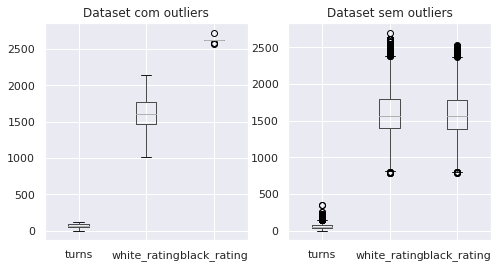

In [13]:
plt.figure(figsize=(8,4)) # Definindo o tamanho e a largura da imagem
plt.subplot(121); dt_out_iqr.boxplot(lst_attr); # A imagem da esquerda tem, após a aplicação do método, dataset com outliers
plt.title('Dataset com outliers');
plt.subplot(122); dt_in_iqr.boxplot(lst_attr);  # A imagem da direita tem, após a aplicação do método, dataset sem outliers
plt.title('Dataset sem outliers');

In [14]:
corr = df_xadrez.corr(method = 'pearson')

# correlação mínima
p = 0.75
# Utilizando o comprenhension para aproveitar conhecimento da outra matéria
var = [[i,j] for i in corr.columns for j in corr.columns if i != j if np.abs(corr[i][j]) >= p]

print(f'Variáveis mais correlacionadas:\n{var}')

Variáveis mais correlacionadas:
[['created_at', 'last_move_at'], ['last_move_at', 'created_at']]


In [15]:
def ExecutarCorrelacao(corr):
    plt.figure(figsize=(8, 7))
    
    my_cols = corr.columns.to_list()
    
    sns.heatmap(np.abs(corr.values), annot=True, cmap='GnBu')
    
    plt.title('Correlação entre os atributos', fontsize=15, fontweight='bold')
    plt.yticks(np.arange(len(my_cols)), my_cols, rotation=0);
    plt.xticks(np.arange(len(my_cols)), my_cols, rotation=90);

In [16]:
ExecutarCorrelacao(corr)

In [17]:
attr = 'victory_status'

plt.hist(df_xadrez[attr]);

In [18]:
attr = 'winner'

plt.hist(df_xadrez[attr]);

##### Análise dos campos created_at e last_move_at

In [19]:
lst_attrib = ['created_at', 'last_move_at', 'spend_time', 'turns']

# Criei um dicionário para evitar o warning settingwithcopywarning: 
# a value is trying to be set on a copy of a slice from a dataframe.
# Esse warning ocorria, pois fazia um processo de slice com criação de nova coluna no dataframe e envolvia o processo de index
dc_st = {lst_attrib[0] : df_xadrez[lst_attrib[0]].values, lst_attrib[1] : df_xadrez[lst_attrib[1]].values,
        lst_attrib[2] : np.nan, lst_attrib[3] : df_xadrez[lst_attrib[3]].values}

spend_time = pd.DataFrame(dc_st)

# Realizei esse cálculo de acordo com o fórum do lichess 
# https://lichess.org/forum/lichess-feedback/query-how-is-time-spent-playing-on-profile-calculated
spend_time[lst_attrib[2]] = spend_time[lst_attrib[1]] - spend_time[lst_attrib[0]]

uni = spend_time[lst_attrib[2]].unique()
tam = len(spend_time[lst_attrib[2]].unique())

print(f'Os campos únicos são: {uni}.\nA quantidade que temos de valores únicos são: '
      f'{tam}')

Os campos únicos são: [       0. 10000000. 20000000. ...   172834.   946699.   736699.].
A quantidade que temos de valores únicos são: 10327


In [20]:
sorted_uni = np.sort(uni)

print(sorted_uni)

[0.00000000e+00 1.92200000e+03 2.53800000e+03 ... 7.23493900e+07
 9.00000000e+07 6.05844701e+08]


In [21]:
spend_time.head(-2)

created_at  last_move_at  spend_time  turns
0      1.504210e+12  1.504210e+12         0.0     13
1      1.504130e+12  1.504130e+12         0.0     16
2      1.504130e+12  1.504130e+12         0.0     61
3      1.504110e+12  1.504110e+12         0.0     61
4      1.504030e+12  1.504030e+12         0.0     95
...             ...           ...         ...    ...
20051  1.499812e+12  1.499813e+12    746494.0     58
20052  1.499812e+12  1.499812e+12    588767.0     37
20053  1.499791e+12  1.499791e+12    321734.0     24
20054  1.499698e+12  1.499699e+12    744219.0     82
20055  1.499698e+12  1.499698e+12    172834.0     35

[20056 rows x 4 columns]

In [22]:
begin = 150
end   = 160

spend_time.iloc[begin:end]

created_at  last_move_at  spend_time  turns
150  1.503050e+12  1.503060e+12  10000000.0     77
151  1.503050e+12  1.503050e+12         0.0     32
152  1.503050e+12  1.503050e+12         0.0     35
153  1.503050e+12  1.503050e+12         0.0     85
154  1.503050e+12  1.503050e+12         0.0     50
155  1.504140e+12  1.504140e+12         0.0    111
156  1.503950e+12  1.503950e+12         0.0     65
157  1.503800e+12  1.503810e+12  10000000.0     73
158  1.503690e+12  1.503690e+12         0.0    125
159  1.503630e+12  1.503630e+12         0.0     76

In [23]:
begin = 1267
end   = 1282

spend_time.iloc[begin:end]

created_at  last_move_at  spend_time  turns
1267  1.503950e+12  1.503950e+12         0.0     14
1268  1.503940e+12  1.503950e+12  10000000.0     51
1269  1.503940e+12  1.503940e+12         0.0     24
1270  1.503940e+12  1.503940e+12         0.0     94
1271  1.503940e+12  1.503940e+12         0.0     24
1272  1.503940e+12  1.503940e+12         0.0     57
1273  1.503890e+12  1.503890e+12         0.0     19
1274  1.503890e+12  1.503890e+12         0.0     47
1275  1.503880e+12  1.503880e+12         0.0     30
1276  1.503880e+12  1.503880e+12         0.0     17
1277  1.503860e+12  1.503860e+12         0.0     18
1278  1.503860e+12  1.503860e+12         0.0     24
1279  1.503860e+12  1.503860e+12         0.0      7
1280  1.503860e+12  1.503860e+12         0.0     27
1281  1.503810e+12  1.503810e+12         0.0     50

In [24]:
spend_time[lst_attrib[2]].value_counts()

0.0           8548
10000000.0     734
496879.0         3
25867.0          3
1816187.0        3
              ... 
518592.0         1
783416.0         1
709501.0         1
193759.0         1
3603429.0        1
Name: spend_time, Length: 10327, dtype: int64

##### Quem vence mais ?

In [25]:
white, black, draws = df_xadrez.winner.value_counts()

In [26]:
white_wins = round(white / df_xadrez.shape[0], 2) * 100
black_wins = round(black / df_xadrez.shape[0], 2) * 100
draws_perc = round(draws / df_xadrez.shape[0], 2) * 100

print(f'Brancas ganharam {white_wins}% dos jogos, enquanto as pretas ganharam {black_wins}%.\nPor fim, os empates'
     f' representaram {draws_perc}% dos jogos.')

Brancas ganharam 50.0% dos jogos, enquanto as pretas ganharam 45.0%.
Por fim, os empates representaram 5.0% dos jogos.


##### Quais jogadas com mais frequência são utilizadas por peças pretas ou brancas

In [27]:
df_open = df_xadrez.groupby(by='opening_name').winner.value_counts()

df_open = df_open.reset_index(name='wins')
df_open = df_open.sort_values(by='wins', ascending=False)

In [28]:
jog_pretas  = df_open[df_open['winner'] == 'black']
jog_brancas = df_open[df_open['winner'] == 'white']
jog_empates = df_open[df_open['winner'] == 'draw']

In [29]:
jog_pretas.head(10)

opening_name winner  wins
2647                   Van't Kruijs Opening  black   226
2189                       Sicilian Defense  black   194
2220       Sicilian Defense: Bowdler Attack  black   164
2064                   Scandinavian Defense  black   123
654        French Defense: Knight Variation  black   121
2114                            Scotch Game  black   115
1771  Queen's Pawn Game: Chigorin Variation  black   109
1793        Queen's Pawn Game: Mason Attack  black   103
821                             Indian Game  black   100
1448                    Philidor Defense #2  black    96

In [30]:
jog_brancas.head(10)

opening_name winner  wins
2095  Scandinavian Defense: Mieses-Kotroc Variation  white   164
2190                               Sicilian Defense  white   149
2113                                    Scotch Game  white   145
653                French Defense: Knight Variation  white   135
1451                            Philidor Defense #3  white   127
2648                           Van't Kruijs Opening  white   126
2221               Sicilian Defense: Bowdler Attack  white   119
1792                Queen's Pawn Game: Mason Attack  white   116
1770          Queen's Pawn Game: Chigorin Variation  white   112
801                                 Horwitz Defense  white   110

In [31]:
jog_empates.head(10)

opening_name winner  wins
2649                    Van't Kruijs Opening   draw    16
655         French Defense: Knight Variation   draw    15
2191                        Sicilian Defense   draw    15
2222        Sicilian Defense: Bowdler Attack   draw    13
1794         Queen's Pawn Game: Mason Attack   draw    13
865                             Italian Game   draw    12
823                              Indian Game   draw    12
2115                             Scotch Game   draw    11
2066                    Scandinavian Defense   draw    10
868   Italian Game: Anti-Fried Liver Defense   draw    10

In [32]:
# Célula que recuperará as 5 melhores aberturas dos jogos com as peças pretas e brancas
black_winner = list(jog_pretas.head().opening_name)
white_winner = list(jog_brancas.head().opening_name)

winner = black_winner + white_winner
dataframes = []

for x in winner:
    temp = df_open[df_open['opening_name'] == x]
    temp['sum'] = temp.wins.sum().astype(int)
    temp['percentage'] = temp['wins'] / temp['sum']
    dataframes.append(temp)
win_prob = dataframes[0]

for x in dataframes[1:]:
    win_prob = pd.concat([win_prob, x])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [33]:
# Método que exibe as 5 melhores jogadas em boxplot
def show_top5_white_black(attr, wb, clr, tlt, xlab, ylab, color):
    x = win_prob[win_prob[attr] == wb].opening_name
    y = win_prob[win_prob[attr] == wb].percentage
    
    plt.figure(dpi=80)
    plt.bar(x, height=y, edgecolor=clr, color = color)
    plt.xticks(rotation='vertical')
    plt.title(tlt)
    plt.xlabel(xlab)
    plt.ylabel(ylab)

In [34]:
attr  = 'winner'
wb    = 'white'
tlt   = 'Porcentagem de vitórias das peças brancas com jogadas iniciais diferentes'
xlab  = 'Abertura'
ylab  = 'Porcentagem'
clr   = 'black'
color = wb

In [35]:
# Gráfico com as peças brancas
show_top5_white_black(attr, wb, clr, tlt, xlab, ylab, color)

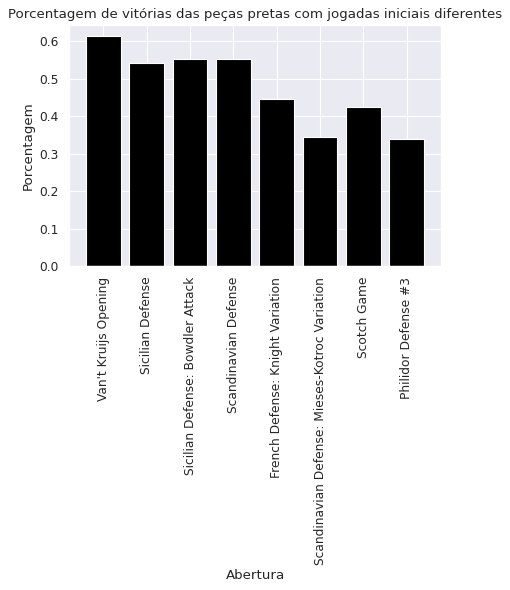

In [36]:
wb    = 'black'
tlt   = 'Porcentagem de vitórias das peças pretas com jogadas iniciais diferentes'
clr   = 'white'
color = wb

# Gráfico com as peças pretas
show_top5_white_black(attr, wb, clr, tlt, xlab, ylab, color)

In [37]:
win_prob

opening_name winner  ...  sum  percentage
2647                           Van't Kruijs Opening  black  ...  368    0.614130
2648                           Van't Kruijs Opening  white  ...  368    0.342391
2649                           Van't Kruijs Opening   draw  ...  368    0.043478
2189                               Sicilian Defense  black  ...  358    0.541899
2190                               Sicilian Defense  white  ...  358    0.416201
2191                               Sicilian Defense   draw  ...  358    0.041899
2220               Sicilian Defense: Bowdler Attack  black  ...  296    0.554054
2221               Sicilian Defense: Bowdler Attack  white  ...  296    0.402027
2222               Sicilian Defense: Bowdler Attack   draw  ...  296    0.043919
2064                           Scandinavian Defense  black  ...  223    0.551570
2065                           Scandinavian Defense  white  ...  223    0.403587
2066                           Scandinavian Defense   draw  ...  223    0.044843
653                French Defense: Knight Variation  white  ...  271    0.498155
654                French Defense: Knight Variation  black  ...  271    0.446494
655                French Defense: Knight Variation   draw  ...  271    0.055351
2095  Scandinavian Defense: Mieses-Kotroc Variation  white  ...  259    0.633205
2096  Scandinavian Defense: Mieses-Kotroc Variation  black  ...  259    0.343629
2097  Scandinavian Defense: Mieses-Kotroc Variation   draw  ...  259    0.023166
2189                               Sicilian Defense  black  ...  358    0.541899
2190                               Sicilian Defense  white  ...  358    0.416201
2191                               Sicilian Defense   draw  ...  358    0.041899
2113                                    Scotch Game  white  ...  271    0.535055
2114                                    Scotch Game  black  ...  271    0.424354
2115                                    Scotch Game   draw  ...  271    0.040590
653                French Defense: Knight Variation  white  ...  271    0.498155
654                French Defense: Knight Variation  black  ...  271    0.446494
655                French Defense: Knight Variation   draw  ...  271    0.055351
1451                            Philidor Defense #3  white  ...  198    0.641414
1452                            Philidor Defense #3  black  ...  198    0.338384
1453                            Philidor Defense #3   draw  ...  198    0.020202

[30 rows x 5 columns]

##### Quem são os 10 melhores jogadores?

In [38]:
def build_dataframe_top_10_players(lst_attra, lst_attrb, df):
    mask = [lst_attra[0], lst_attra[1]]
    white_player_df = df[mask]
    white_player_df.columns = [lst_attrb[0], lst_attrb[1]]
    
    mask = [lst_attra[2], lst_attra[3]]
    black_player_df = df[mask]
    black_player_df = black_player_df[mask]
    black_player_df.columns = [lst_attrb[0], lst_attrb[1]]
    
    best_players = pd.concat([white_player_df, black_player_df])
    
    return best_players

In [39]:
lst_attra = ['white_id', 'white_rating', 'black_id', 'black_rating']
lst_attrb = ['player_id', 'player_rating']

top_jogadores = build_dataframe_top_10_players(lst_attra, lst_attrb, df_xadrez)

In [40]:
ID = []
rating = []

for x in top_jogadores.player_id.unique():
    ID.append(x)
    
    temp = top_jogadores[top_jogadores[lst_attrb[0]] == x]
    rating.append(temp.player_rating.max())

top_jogadores = pd.DataFrame()
top_jogadores[lst_attrb[0]] = np.array(ID)
top_jogadores[lst_attrb[1]] = np.array(rating)

In [41]:
top_10 = top_jogadores.sort_values(by='player_rating', ascending=False).head(10)

plt.figure(dpi=100)
plt.bar(x=top_10.player_id, height=top_10.player_rating, edgecolor='green', color='pink');

plt.title('Top 10 jogadores por rating');
plt.xlabel('Jogador - ID');
plt.ylabel('Jogador - Rating');

plt.xticks(rotation=90);

In [42]:
players = list(top_10.player_id)

pla_ope = df_xadrez.query('white_id == @players | black_id == @players').opening_name.value_counts()

pla_ope.head(10)

Sicilian Defense: Modern Variations |  Anti-Qxd4 Move Order                   4
Sicilian Defense: Classical Variation                                         3
Queen's Pawn                                                                  3
Caro-Kann Defense: Tartakower Variation                                       2
Caro-Kann Defense: Two Knights Attack |  Mindeno Variation |  Retreat Line    2
Italian Game: Two Knights Defense |  Polerio Defense |  Suhle Defense         2
Queen's Gambit Declined: Tartakower Variation |  Exchange Variation           2
Italian Game: Giuoco Pianissimo |  Italian Four Knights Variation             2
Queen's Gambit Declined: Westphalian Variation                                2
Scotch Game                                                                   2
Name: opening_name, dtype: int64

#### Explorando as possibilidades da jogada Slav Defense: Exchange Variation

In [43]:
df_opening = df_xadrez.query('opening_name == "Slav Defense: Exchange Variation"')
df_group   = df_opening.groupby(['opening_eco','opening_ply']).max()

df_group.index

MultiIndex([('D10', 5),
            ('D13', 8)],
           names=['opening_eco', 'opening_ply'])

In [44]:
df_opening['opening_ply'].unique()

array([5, 8])

In [45]:
df_opening['opening_eco'].unique()

array(['D10', 'D13'], dtype=object)

### Implementação com SVM e Random Forest

<span style='color:black'>
    Nesta parte aplicaremos os modelos com a utilização de algumas features, predizer quem é o vencedor e utilizar o random forest para indicar os atributos mais importantes.<br>
    Os atributos escolhidos são:<br>
    <ul>
        <li>white_id</li>
        <li>white_rating</li>
        <li>black_id</li>
        <li>black_rating</li>
        <li>opening_eco</li>
        <li>opening_name</li>
        <li>opening_ply</li>
    </ul>
    <br> O alvo é o: <strong>winner</strong>.<br>Onde o modelo tentará prever quem será o vencedor da partida.
</span>

In [46]:
# Criei um método para facilitar as alterações que farei nos parâmetros e evitar redundância de código
def RelativeImportance(model, X):
    features_names = X.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    #lmeas_order = []
       
    #for i in indices:
    #    lmeas_order.append(features_names[i])
    
    lmeas_order = [features_names[i] for i in indices]
    
    4#lmeas_order = list(map(lambda i: features_names[i], indices))

    plt.figure(figsize=(12,8))
    #sns.barplot(list(range(len(indices))), list(importances[indices]))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), lmeas_order, fontsize=15)
    plt.xlabel('Relative Importance',fontsize=15)
    plt.xticks(color='k', size=20)
    plt.yticks(color='k', size=20)
    plt.show()

In [47]:
def ExecutarSVM(X_train, Y_train, kernel = 'rbf', n_splits = 5):
        
    # Realizando a divisão de folds de forma a atenuar o problema de classes desbalanceadas
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    mf1s = []
    mbas = []
    vc = []
    
    for c in range(1, 30):
        vf1s = []
        vbas = []
        
        for train_index, test_index in cv.split(X_train, Y_train):
            # select rows
            x_train, x_test = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train, y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]
            
            model = SVC(C = c, gamma = 'auto', kernel = kernel)
            model.fit(x_train,y_train)
            y_pred = model.predict(x_test) 
            score = balanced_accuracy_score(y_test, y_pred)
            
            #with warnings.catch_warnings():
            #    warnings.simplefilter("ignore")
            vf1s.append(f1_score(y_test, y_pred, average='weighted'))
                
            vbas.append(score)
            
        mbas.append(np.mean(vbas))
        mf1s.append(np.mean(vf1s))
        vc.append(c)
        
    best_c = np.argmax(mbas)+1
    print(f'Melhor c: {best_c} e Acurácia Balanceada: {mbas[best_c - 1]}')
    plt.figure(figsize=(10,5))
    plt.plot(vc, mf1s, '-ro', label= 'F1 Score')
    plt.plot(vc, mbas, '-bo', label = 'Balanced Accuracy')
    plt.xlabel('c', fontsize = 15)
    plt.ylabel('Score', fontsize = 15)
    plt.legend()
    plt.show()
    
    return best_c

In [48]:
# Método para evitar código duplicado e será o que vai indentificar a minha acurácia para o SVM
# A escolha do C como default foi randômica
def Metric_SVM(x_train, x_test, y_train, y_test, best_c = 10, kernel = 'rbf'):
    
    model = SVC(C = best_c, gamma = 'auto', kernel = kernel)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test) 
    
    score = f1_score(y_test, y_pred, average = 'weighted')
    
    print(f"F1 Score: {score:.4f}")

In [49]:
def ExecutarRandomForest(X_train, Y_train, criterion = 'gini', n_splits = 5):
    
    # Realizando a divisão de folds de forma a atenuar o problema de classes desbalanceadas
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    mf1s = []
    mbas = []
    vc = []
    
    for n in range(1, 30):
        vf1s = []
        vbas = []
        
        for train_index, test_index in cv.split(X_train, Y_train):
            # select rows
            x_train, x_test = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train, y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]
            
            model = RandomForestClassifier(n_estimators=n, bootstrap=True, class_weight=None, criterion=criterion,
                                                max_depth=None, max_features='auto', max_leaf_nodes=None,
                                                min_impurity_decrease=0.0, min_impurity_split=None,
                                                min_samples_leaf=1, min_samples_split=2,
                                                min_weight_fraction_leaf=0.0, n_jobs=1,
                                                oob_score=False, random_state=None, verbose=0,
                                                warm_start=False)
            
            model.fit(x_train,y_train)
            y_pred = model.predict(x_test) 
            
            #with warnings.catch_warnings():
            #    warnings.simplefilter("ignore")
            
            vbas.append(balanced_accuracy_score(y_test, y_pred))
            vf1s.append(f1_score(y_test, y_pred, average='weighted'))
            
        mbas.append(np.mean(vbas))
        mf1s.append(np.mean(vf1s))
        vc.append(n)

    best_n = np.argmax(mbas)+1
    print(f'Melhor n: {best_n} e Acurácia Balanceada: {mbas[best_n - 1]}')
    plt.figure(figsize=(10,5))
    plt.plot(vc, mf1s, '-ro', label= 'F1 Score')
    plt.plot(vc, mbas, '-bo', label = 'Balanced Accuracy')
    plt.xlabel('n', fontsize = 15)
    plt.ylabel('Score', fontsize = 15)
    plt.legend()
    plt.show()
    
    return best_n

In [50]:
# A escolha do valor 100 para o parâmetro best_n foi randômica. Visto nas aulas a utilização do valor 100
def Metric_RandomForest(x_train, x_test, y_train, y_test, best_n = 100, criterion='gini'):
    
    model=RandomForestClassifier(n_estimators=best_n, bootstrap=True, class_weight=None, criterion=criterion,
                                max_depth=None, max_features='auto', max_leaf_nodes=None,
                                min_impurity_decrease=0.0, min_impurity_split=None,
                                min_samples_leaf=1, min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_jobs=1,
                                oob_score=False, random_state=None, verbose=0,
                                warm_start=False)
    model.fit(x_train, y_train)    
    y_pred = model.predict(x_test)
    
    score = f1_score(y_test, y_pred, average = 'weighted')
    print(f'F1 Score: {score:.4f}')

In [51]:
# Criei um método para facilitar as alterações que farei nos parâmetros e evitar redundância de código
def ExecuteRandomForest(x_train, y_train, n = 100, criterion='gini'):
    model = RandomForestClassifier(n_estimators=n, bootstrap=True, class_weight=None, criterion=criterion,
                                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                                    min_impurity_decrease=0.0, min_impurity_split=None,
                                    min_samples_leaf=1, min_samples_split=2,
                                    min_weight_fraction_leaf=0.0, n_jobs=1,
                                    oob_score=False, random_state=None, verbose=0,
                                    warm_start=False)
    model.fit(x_train, y_train)
    
    return model

#### Transformar os atributos objetos em numéricos

In [52]:
# Realizando a cópia dos dataframes
lichess = df_xadrez.copy(deep = True)

In [53]:
qtt_on = len(lichess['opening_name'].unique())
qtt_oe = len(lichess['opening_eco'].unique())
qtt_wi = len(lichess['white_id'].unique())
qtt_bi = len(lichess['black_id'].unique())

print(f'A quantidade de opening_name é: {qtt_on}\nA quantidade de opening_eco é: {qtt_oe}\nA quantidade de white_id é: '
      f'{qtt_wi}\nE a quantidade de black_id é: {qtt_bi}')

A quantidade de opening_name é: 1477
A quantidade de opening_eco é: 365
A quantidade de white_id é: 9438
E a quantidade de black_id é: 9331


In [54]:
def ordinal_encoder(df, lst, attr, attr_new):
    # Instanciando o OrdinalEncoder e passando as categorias
    oe = OrdinalEncoder(categories=[lst])
    
    # Realizar a transformação e gerar os números para as categorias
    df[attr_new] = oe.fit_transform(df[[attr]])
    
    # Retornando o atributo após o OrdinalEncoder
    return df[attr_new]

In [55]:
attr_new = 'opening_eco_oe'
attr     = 'opening_eco'
lst_oe   = lichess[attr].unique().tolist()

lichess[attr_new] = ordinal_encoder(lichess, lst_oe, attr, attr_new)

attr_new = 'opening_name_oe'
attr     = 'opening_name'
lst_oe   = lichess[attr].unique().tolist()

lichess[attr_new] = ordinal_encoder(lichess, lst_oe, attr, attr_new)

lichess.head()

id  rated    created_at  ...  opening_ply  opening_eco_oe opening_name_oe
0  TZJHLljE  False  1.504210e+12  ...            5             0.0             0.0
1  l1NXvwaE   True  1.504130e+12  ...            4             1.0             1.0
2  mIICvQHh   True  1.504130e+12  ...            3             2.0             2.0
3  kWKvrqYL   True  1.504110e+12  ...            3             3.0             3.0
4  9tXo1AUZ   True  1.504030e+12  ...            5             4.0             4.0

[5 rows x 18 columns]

In [56]:
lst_white_id = lichess['white_id'].unique().tolist()
lst_black_id = lichess['black_id'].unique().tolist()

lst_ids = lst_white_id
lst_ids.extend(lst_black_id)

dc_names = dict(Counter(lst_ids))
dc_ids   = {v:count for count,v in enumerate(lst_ids, 1)}

In [57]:
from functools import reduce

cnt = reduce(lambda x,y: x+y, dc_names.values())

print(cnt)

18769


In [58]:
def map_attr_new(df, attr, attr_new, dct):
    
    # Realizando o map dos nomes dos jogadores
    df[attr_new] = df[attr].map(dct)
    
    # Retornando um novo campo
    return df[attr_new]

In [59]:
attr = 'white_id'
attr_new = 'white_id_map'

lichess[attr_new] = map_attr_new(lichess, attr, attr_new, dc_ids)

attr = 'black_id'
attr_new = 'black_id_map'

lichess[attr_new] = map_attr_new(lichess, attr, attr_new, dc_ids)

In [60]:
# Realizando o label encoder em winner - target
le = LabelEncoder()

# Inicialização do target
target = 'winner'

# Novo campo do target em numérico
target_new = 'winner_le'

lichess[target_new] = le.fit_transform(df_xadrez[target])

lichess.head()

id  rated    created_at  ...  white_id_map  black_id_map winner_le
0  TZJHLljE  False  1.504210e+12  ...             1          9439         2
1  l1NXvwaE   True  1.504130e+12  ...          9439          9440         0
2  mIICvQHh   True  1.504130e+12  ...             3          9439         2
3  kWKvrqYL   True  1.504110e+12  ...             4          9441         2
4  9tXo1AUZ   True  1.504030e+12  ...             5          9441         2

[5 rows x 21 columns]

In [61]:
lichess.head()

id  rated    created_at  ...  white_id_map  black_id_map winner_le
0  TZJHLljE  False  1.504210e+12  ...             1          9439         2
1  l1NXvwaE   True  1.504130e+12  ...          9439          9440         0
2  mIICvQHh   True  1.504130e+12  ...             3          9439         2
3  kWKvrqYL   True  1.504110e+12  ...             4          9441         2
4  9tXo1AUZ   True  1.504030e+12  ...             5          9441         2

[5 rows x 21 columns]

In [62]:
lichess[target_new].unique()

array([2, 0, 1])

<span style='color:black'>
    Após a execução do label encoder no rótulo da primeira pesquisa, quem venceu ou não. Percebemos que é uma tarefa multiclasse, com consideração do empate.<br> O LabelEncoder dividiu da seguinte maneira:
    <ul>
        <li>0: Vitória das peças pretas</li>
        <li>1: Empate</li>
        <li>2: Vitória das peças brancas</li>
    </ul>
</span>

In [63]:
lst_lichess = ['white_id_map', 'white_rating', 'black_id_map', 'black_rating', 'opening_eco_oe', 'opening_name_oe',
               'opening_ply', 'winner_le']

lichess = lichess[lst_lichess]

lichess.head()

white_id_map  white_rating  ...  opening_ply  winner_le
0             1          1500  ...            5          2
1          9439          1322  ...            4          0
2             3          1496  ...            3          2
3             4          1439  ...            3          2
4             5          1523  ...            5          2

[5 rows x 8 columns]

In [64]:
lichess.describe()

white_id_map  white_rating  ...   opening_ply     winner_le
count  20058.000000  20058.000000  ...  20058.000000  20058.000000
mean   10546.283378   1596.631868  ...      4.816981      1.044571
std     5253.129705    291.253376  ...      2.797152      0.975038
min        1.000000    784.000000  ...      1.000000      0.000000
25%     6335.000000   1398.000000  ...      3.000000      0.000000
50%    11209.000000   1567.000000  ...      4.000000      1.000000
75%    15021.000000   1793.000000  ...      6.000000      2.000000
max    18766.000000   2700.000000  ...     28.000000      2.000000

[8 rows x 8 columns]

In [65]:
# Este método serve para separação da classe
def SeparacaoClasse(data = lichess, target = 'winner_le'):
    # Separando meu atributo target dos demais atributos
    features = list(data.columns)
    features.remove(target)

    # Separando os conjuntos
    X = data[features]
    y = data[target]

    # Conferindo se os formatos estão corretos
    print(X.shape)
    print(y.shape)
    
    return X, y

In [66]:
# Usando meu dataframe lichess com o padrão do target para winner_le
X, y = SeparacaoClasse(lichess)

(20058, 7)
(20058,)


In [67]:
# Método para evitar codigo duplicado
def HoldOut(X_hold_out = X, y_hold_out = y, size = 0):
    # Separando o conjunto de treinamento e de testes - Utilizando a técnica Hold Out
    x_train, x_test, y_train, y_test = train_test_split(X_hold_out, y_hold_out, test_size=size, random_state=0)

    # Verificando se está tudo certo
    print('--------------------------------')
    print(f'Conjunto de treino:\n\t'
          f'Atributos = {x_train.shape}\n\t'
          f'Alvo      = {y_train.shape}\n')
    print(f'Conjunto de Teste:\n\t'
          f'Atributos = {x_test.shape}\n\t'
          f'Alvo      = {y_test.shape}')
    
    return x_train, x_test, y_train, y_test

In [68]:
size = 0.25

x_train, x_test, y_train, y_test = HoldOut(X, y, size)

--------------------------------
Conjunto de treino:
	Atributos = (15043, 7)
	Alvo      = (15043,)

Conjunto de Teste:
	Atributos = (5015, 7)
	Alvo      = (5015,)


In [69]:
# Convertendo os dados de treino e teste para padronização
x_train_scaled = x_train.copy(deep=True)
x_test_scaled = x_test.copy(deep=True)

scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled.iloc[:, :] = scaler.transform(x_train)
x_test_scaled.iloc[:, :]  = scaler.transform(x_test)

#### Executar os modelos - SVM e RF

In [70]:
n_splits = 10

# Dados padronizados e o kernel rbf setado na inicialização do método
best_cr = ExecutarSVM(x_train_scaled[:5000], y_train[:5000], n_splits = n_splits)

Melhor c: 1 e Acurácia Balanceada: 0.42747802676747326


In [71]:
Metric_SVM(x_train_scaled[:5000], x_test_scaled, y_train[:5000], y_test, best_cr)

F1 Score: 0.5942


Melhor c: 1 e Acurácia Balanceada: 0.43378146963694153


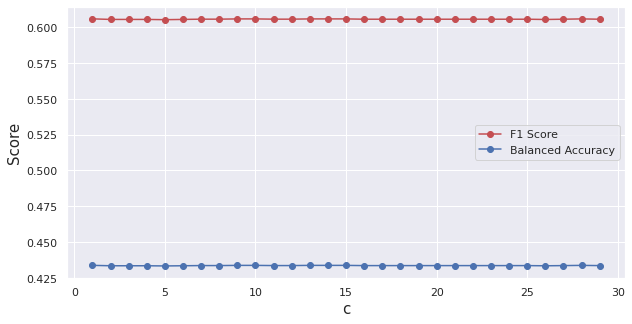

In [72]:
n_splits = 10
kernel = 'linear'

# Dados padronizados e o kernel rbf setado na inicialização do método
best_cl = ExecutarSVM(x_train_scaled[:5000], y_train[:5000], kernel=kernel, n_splits = n_splits)

In [73]:
Metric_SVM(x_train_scaled[:5000], x_test_scaled, y_train[:5000], y_test, best_cl)

F1 Score: 0.5942


In [74]:
best_ng = ExecutarRandomForest(x_train_scaled[:5000], y_train[:5000], n_splits = n_splits)

Melhor n: 27 e Acurácia Balanceada: 0.4440696723479761


In [75]:
Metric_RandomForest(x_train_scaled[:5000], x_test_scaled, y_train[:5000], y_test, best_ng)

F1 Score: 0.5964


Melhor n: 24 e Acurácia Balanceada: 0.4501921530728314


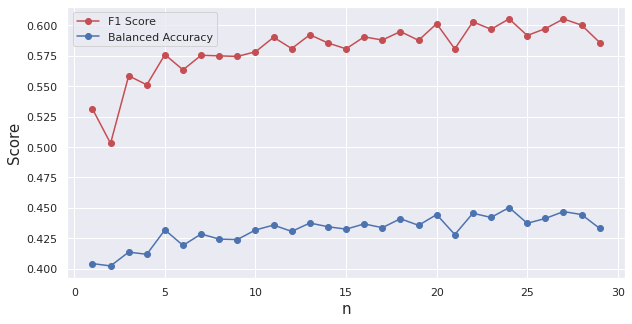

In [76]:
crit = 'entropy'

best_ne = ExecutarRandomForest(x_train_scaled[:5000], y_train[:5000], criterion = crit, n_splits = n_splits)

In [77]:
Metric_RandomForest(x_train_scaled[:5000], x_test_scaled, y_train[:5000], y_test, best_ne, crit)

F1 Score: 0.5925


In [78]:
# Criei um método com os melhores parâmetros e para visualizar o resultado de cada um num mesmo gráfico
def ExecutarTodosModelos(x_train, x_test, y_train, y_test, best_ng, best_ne, best_cr, best_cl):
    
    models = {
        'Random Forest - Gini': RandomForestClassifier
                                             (n_estimators=best_ng, bootstrap=True, class_weight=None, criterion='gini',
                                                max_depth=None, max_features='auto', max_leaf_nodes=None,
                                                min_impurity_decrease=0.0, min_impurity_split=None,
                                                min_samples_leaf=1, min_samples_split=2,
                                                min_weight_fraction_leaf=0.0, n_jobs=1,
                                                oob_score=False, random_state=42, verbose=0,
                                                warm_start=False),
        'Random Forest - Entropy': RandomForestClassifier
                                             (n_estimators=best_ne, bootstrap=True, class_weight=None, criterion='entropy',
                                                max_depth=None, max_features='auto', max_leaf_nodes=None,
                                                min_impurity_decrease=0.0, min_impurity_split=None,
                                                min_samples_leaf=1, min_samples_split=2,
                                                min_weight_fraction_leaf=0.0, n_jobs=1,
                                                oob_score=False, random_state=42, verbose=0,
                                                warm_start=False),
        'Support Vector Machine - Kernel RBF': SVC(C = best_cr, gamma = 'auto', random_state=42),
        'Support Vector Machine - Kernel Linear': SVC(C = best_cl, gamma = 'auto', kernel='linear', random_state=42)
    }

    # Onde vou salvar as acurácias
    scores = {}

    for name, model in models.items():
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
    
        f1s = f1_score(y_test, y_pred, average = 'weighted')
        scores[name] = round(f1s,4)
    
        print(f'F1 Score {name}: \t{f1s:.4f}')
    
    return scores

In [79]:
scores = ExecutarTodosModelos(x_train_scaled[:5000], x_test_scaled, y_train[:5000], y_test, best_ng, best_ne, best_cr, best_cl)

F1 Score Random Forest - Gini: 	0.5911
F1 Score Random Forest - Entropy: 	0.5867
F1 Score Support Vector Machine - Kernel RBF: 	0.5942
F1 Score Support Vector Machine - Kernel Linear: 	0.6052


In [80]:
# Plotando gráfico com os classificadores utilizando o dado padronizado
plt.figure(figsize=(10, 5))

sns.barplot(list(scores.values()), list(scores.keys()))
plt.xticks(np.arange(0, 0.9, 0.2));
plt.xlabel('F1 Score')
plt.ylabel('Modelos')
plt.title('Comparação Modelos - Classificação')

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Comparação Modelos - Classificação')

In [81]:
# Geração do modelo com o viés de dados normalizados, estimadores = 100 e o critério gini
model = ExecuteRandomForest(x_train_scaled, y_train)

RelativeImportance(model, x_train_scaled)

In [82]:
# Geração do modelo com o viés de dados normalizados, estimadores = 100 e o critério entropy
model = ExecuteRandomForest(x_train_scaled, y_train, criterion = crit)

RelativeImportance(model, x_train_scaled)

<span style='color:black'>
    <strong>Para cada jogador qual porcentagem de vitória dos jogadores? tirar a média, mediana (arredondar sem casa decimal) e desvio padrão da porcentagem de vitória de cada jogador.</strong>
</span>

In [83]:
a4_dims = (21, 6)
fig, ax = plt.subplots(1,2,figsize=a4_dims)
wr = 'white_rating'
br = 'black_rating'

# Distribuição dos jogadores com peças brancas
sns.histplot(df_xadrez[wr], bins = 30, ax = ax[0], kde=True)
# Distribuição dos jogadores com peças pretas
sns.histplot(df_xadrez[br], bins = 30, ax = ax[1], kde=True)

ax_attr = ax[0].set(title = "Distribuição da Avaliação de Peças Brancas")
ax_attr = ax[1].set(title = "Distribuição da Avaliação de Peças Pretas")

# Média do rating das peças brancas e pretas
print(f'A média da avaliação das peças brancas é:\t{df_xadrez[wr].mean()}\n'
      f'A média da avaliação das peças pretas é:\t{df_xadrez[br].mean()}')

A média da avaliação das peças brancas é:	1596.6318675840064
A média da avaliação das peças pretas é:	1588.8319872370128


In [84]:
lst_attr = ['white_id','black_id']

df_play = df_xadrez.groupby(by=lst_attr).winner.value_counts()

df_play = df_play.reset_index(name='wins')
df_play = df_play.sort_values(by='wins', ascending=False)

In [85]:
df_play.head(50)

white_id          black_id winner  wins
3427             chiggen           drakon1  white    15
12964      projetoxadrez   thebestofthebad  white    15
4862        duckduckfrog  smartduckduckcow  black    15
15924    thebestofthebad     projetoxadrez  black    14
99            aaaaaaaddd             cfc52  white    12
9948             lzchips   solidchess_hehe  white    12
3375        chesswithmom         schoonied  white    12
15035    solidchess_hehe           lzchips  black    12
15909         thebadfish            crraii  white    11
18084              zher0         shaeila89  white    10
14307          schoonied      chesswithmom  black    10
15910         thebadfish            crraii  black     9
4627             dkattir       mansoor_k11  white     8
15589    tactical_bishop     sneaky_bugger  black     8
348           ahmedgomez    mahmoud_safyan  black     8
4788             drakon1           chiggen  black     8
14996      sneaky_bugger   tactical_bishop  white     8
3858              crraii        thebadfish  white     8
10183        mansoor_k11           dkattir  black     8
3275    chesslearningpro        enricolord  white     7
16606                trx            motion  black     7
11192             motion               trx  white     6
3129         chess-brahs          arda2828  white     6
12490         paulorojas            javi_r  white     6
17195          vkmansftw     a_p_t_e_m_u_u  black     6
5349          enricolord  chesslearningpro  black     6
5350          enricolord  chesslearningpro  white     6
12299          paddy1992          b2g4gotu  black     6
10045     mahmoud_safyan        ahmedgomez  white     6
8091       joelitrox1234      lichessfiend  black     5
3276    chesslearningpro        enricolord  black     5
10909         mineralkin           dfdghgh  black     5
3039               cfc52        aaaaaaaddd  black     5
3132         chess-brahs              cdvh  black     5
10446         mathhopper      barrow-wight  black     5
2952        carson_wells           fistiko  black     5
11319           mrzoom47     xblazin_grape  white     5
10772          micaiahwa           beastly  white     5
6574      grundlesniffer          tomo1997  white     5
1762            b2g4gotu         paddy1992  white     5
15692            taranga            moon50  white     4
10287         marmoraka5           taranga  black     4
7517   italiantranslator           taranga  black     4
16377             tori92           2700172  white     4
903             ammanian            zoro94  white     4
15699            taranga           snapper  white     4
8659             kerilka          mika2012  black     4
15696            taranga    piroz_xucestih  black     4
15695            taranga           naoufel  black     4
3119              chenla       romanar2006  white     4

In [86]:
# Método serve para trazer a porcentagem de vitória de cada jogador com uma determinada peça
def mapear_vitoria_jogadores_pecas(lst_jogadores, query = '', pecas_analise = '', adversario = ''):

  # Lista das médias
  lst_medias = []

  if (pecas_analise == 'white'):
    
    for player in lst_jogadores:
            
      matches_played = df_xadrez.query(query).shape[0]
      df_player   = df_xadrez.query(query)
            
      cenario_jogo = len(set(df_player.winner))
            
      if cenario_jogo == 3:
                                          
        print(f'O jogador {player} jogou com peças {pecas_analise} {matches_played} vezes e o resultado foi:')
                
        if df_player.winner.value_counts().index[0] == "white" and df_player.winner.value_counts().index[1] == "black":
                             
          print(f'\tVitória com peças {pecas_analise}: {df_player.winner.value_counts()[0]}\n\t'
                f'Derrota para peças {adversario}: {df_player.winner.value_counts()[1]}\n\t'
                f'Empates             : {df_player.winner.value_counts()[2]}')
                
          porc_vit = round((df_player.winner.value_counts()[0] / matches_played) * 100, 2)
          media    = df_player.winner.value_counts()[0] / matches_played

          lst_medias.append(media)
                    
        elif df_player.winner.value_counts().index[0] == "black" and df_player.winner.value_counts().index[1] == "white":
                              
          print(f'\tVitória com peças {pecas_analise}: {df_player.winner.value_counts()[1]}\n\t'
                f'Derrota para peças {adversario}: {df_player.winner.value_counts()[0]}\n\t'
                f'Empates             : {df_player.winner.value_counts()[2]}')
                
          porc_vit = round((df_player.winner.value_counts()[1] / matches_played) * 100, 2)
          media    = df_player.winner.value_counts()[1] / matches_played

          lst_medias.append(media)       
                    
        elif df_player.winner.value_counts().index[0] == "white" and df_player.winner.value_counts().index[1] == "draw":

          print(f'\tVitória com peças {pecas_analise}: {df_player.winner.value_counts()[0]}\n\t'
                          f'Derrota para peças {adversario}: {df_player.winner.value_counts()[2]}\n\t'
                          f'Empates             : {df_player.winner.value_counts()[1]}')
                
          porc_vit = round((df_player.winner.value_counts()[0] / matches_played) * 100, 2)
          media    = df_player.winner.value_counts()[0] / matches_played

          lst_medias.append(media)       
      
        elif df_player.winner.value_counts().index[0] == "draw" and df_player.winner.value_counts().index[1] == "white":
            
          print(f'\tVitória com peças {pecas_analise}: {df_player.winner.value_counts()[1]}\n\t'
                f'Derrota para peças {adversario}: {df_player.winner.value_counts()[2]}\n\t'
                f'Empates             : {df_player.winner.value_counts()[0]}')
          
          porc_vit = round((df_player.winner.value_counts()[1] / matches_played) * 100, 2)
          media    = df_player.winner.value_counts()[1] / matches_played

          lst_medias.append(media)
            
        elif df_player.winner.value_counts().index[0] == "black" and df_player.winner.value_counts().index[1] == "draw":  
          print(f'\tVitória com peças {pecas_analise}: {df_player.winner.value_counts()[2]}\n\t'
                f'Derrota para peças {adversario}: {df_player.winner.value_counts()[0]}\n\t'
                f'Empates             : {df_player.winner.value_counts()[1]}')
      
          porc_vit = round((df_player.winner.value_counts()[2] / matches_played) * 100, 2)
          media    = df_player.winner.value_counts()[2] / matches_played

          lst_medias.append(media)  
            
        else:            
            
          print(f'\tVitória com peças {pecas_analise}: {df_player.winner.value_counts()[2]}\n\t'
                f'Derrota para peças {adversario}: {df_player.winner.value_counts()[1]}\n\t'
                f'Empates             : {df_player.winner.value_counts()[0]}')
      
          porc_vit = round((df_player.winner.value_counts()[2] / matches_played) * 100, 2)
          media    = df_player.winner.value_counts()[2] / matches_played

          lst_medias.append(media)                 
        
        print(f'\nA média de vitória desse jogador é de: {media:.2f}\nE sua porcentagem equivale à: {porc_vit}%\n')

      elif cenario_jogo == 2:
                
        print(f'O jogador {player} jogou com peças {pecas_analise} {matches_played} vezes e o resultado foi:')
        
        if df_player.winner.value_counts().index[0] == "white" and df_player.winner.value_counts().index[1] == "black":
          print(f'\tVitória com peças {pecas_analise}: {df_player.winner.value_counts()[0]}\n\t'
                f'Derrota para peças {adversario}: {df_player.winner.value_counts()[1]}')
            
          porc_vit = round((df_player.winner.value_counts()[0] / matches_played) * 100, 2)
          media    = df_player.winner.value_counts()[0] / matches_played

          lst_medias.append(media)
            
        elif df_player.winner.value_counts().index[0] == "black" and df_player.winner.value_counts().index[1] == "white":
          print(f'\tDerrota para peças {adversario}: {df_player.winner.value_counts()[0]}\n\t'
                f'Vitória com peças {pecas_analise}: {df_player.winner.value_counts()[1]}')
            
          porc_vit = round((df_player.winner.value_counts()[1] / matches_played) * 100, 2)
          media    = df_player.winner.value_counts()[1] / matches_played

          lst_medias.append(media)
            
        elif df_player.winner.value_counts().index[0] == "black" and df_player.winner.value_counts().index[1] == "draw":
          print(f'\tDerrota para peças {adversario}: {df_player.winner.value_counts()[0]}\n\t'
                f'Empates             : {df_player.winner.value_counts()[1]}')
            
          porc_vit = 0
          media    = 0

          lst_medias.append(media)
            
        elif df_player.winner.value_counts().index[0] == "draw" and df_player.winner.value_counts().index[1] == "black":
          print(f'\tEmpates: {df_player.winner.value_counts()[0]}\n\t'
                f'Derrota para peças {adversario}: {df_player.winner.value_counts()[1]}')
            
          porc_vit = 0
          media    = 0

          lst_medias.append(media)
            
        elif df_player.winner.value_counts().index[0] == "white" and df_player.winner.value_counts().index[1] == "draw":
          print(f'\tVitória com peças {pecas_analise}: {df_player.winner.value_counts()[0]}\n\t'
                f'Empates: {df_player.winner.value_counts()[1]}')
           
          porc_vit = round((df_player.winner.value_counts()[0] / matches_played) * 100, 2)
          media    = df_player.winner.value_counts()[0] / matches_played

          lst_medias.append(media)
            
        else:            
          print(f'\tEmpates           : {df_player.winner.value_counts()[0]}\n\t'
                f'Vitória com peças {pecas_analise}: {df_player.winner.value_counts()[1]}')
        
          porc_vit = round((df_player.winner.value_counts()[1] / matches_played) * 100, 2)
          media    = df_player.winner.value_counts()[1] / matches_played

          lst_medias.append(media)
        
        print(f'\nA média de vitória desse jogador é de: {media:.2f}\nE sua porcentagem equivale à: {porc_vit}%\n')
                
      elif cenario_jogo == 1:
                
        if df_player.winner.value_counts().index == 'white':
          jogo = 'vitória' 
            
          media = 1.0
          porc_vit = media * 100

          lst_medias.append(media)
            
        elif df_player.winner.value_counts().index == 'black':
          jogo = 'derrota'

          media = 0
          lst_medias.append(media)
            
        else:
          jogo = 'empate'

          media = 0
          lst_medias.append(media)
        
        print(f'O {player} realizou {matches_played} partida(s) e o(s) resultado(s)'
              f' foi/foram:\n\t{jogo}\n')
        
  else:
    for player in lst_jogadores:
          
      matches_played = df_xadrez.query(query).shape[0]
      df_player   = df_xadrez.query(query)
      
      cenario_jogo = len(set(df_player.winner))
      
      if cenario_jogo == 3:
                                     
        print(f'O jogador {player} jogou com peças {pecas_analise} {matches_played} vezes e o resultado foi:')
          
        if df_player.winner.value_counts().index[0] == "white" and df_player.winner.value_counts().index[1] == "black":

          print(f'\tVitória com peças {pecas_analise}: {df_player.winner.value_counts()[1]}\n\t'
                f'Derrota para peças {adversario}: {df_player.winner.value_counts()[0]}\n\t'
                f'Empates             : {df_player.winner.value_counts()[2]}')
          
          porc_vit = round((df_player.winner.value_counts()[1] / matches_played) * 100, 2)
          media    = df_player.winner.value_counts()[1] / matches_played

          lst_medias.append(media)            
              
        elif df_player.winner.value_counts().index[0] == "black" and df_player.winner.value_counts().index[1] == "white":
              
          print(f'\tVitória com peças {pecas_analise}: {df_player.winner.value_counts()[0]}\n\t'
                f'Derrota para peças {adversario}: {df_player.winner.value_counts()[1]}\n\t'
                f'Empates             : {df_player.winner.value_counts()[2]}')
          
          porc_vit = round((df_player.winner.value_counts()[0] / matches_played) * 100, 2)
          media    = df_player.winner.value_counts()[0] / matches_played

          lst_medias.append(media)  
              
        elif df_player.winner.value_counts().index[0] == "white" and df_player.winner.value_counts().index[1] == "draw":
            
          print(f'\tVitória com peças {pecas_analise}: {df_player.winner.value_counts()[2]}\n\t'
                f'Derrota para peças {adversario}: {df_player.winner.value_counts()[0]}\n\t'
                f'Empates             : {df_player.winner.value_counts()[1]}')
      
          porc_vit = round((df_player.winner.value_counts()[2] / matches_played) * 100, 2)
          media    = df_player.winner.value_counts()[2] / matches_played

          lst_medias.append(media)
        
        elif df_player.winner.value_counts().index[0] == "draw" and df_player.winner.value_counts().index[1] == "white":
            
          print(f'\tVitória com peças {pecas_analise}: {df_player.winner.value_counts()[2]}\n\t'
                f'Derrota para peças {adversario}: {df_player.winner.value_counts()[1]}\n\t'
                f'Empates             : {df_player.winner.value_counts()[0]}')
          
          lst_medias.append(media)
          
          porc_vit = round((df_player.winner.value_counts()[2] / matches_played) * 100, 2)
          media    = df_player.winner.value_counts()[2] / matches_played

          lst_medias.append(media)
            
        elif df_player.winner.value_counts().index[0] == "black" and df_player.winner.value_counts().index[1] == "draw":
            
          print(f'\tVitória com peças {pecas_analise}: {df_player.winner.value_counts()[0]}\n\t'
                f'Derrota para peças {adversario}: {df_player.winner.value_counts()[2]}\n\t'
                f'Empates             : {df_player.winner.value_counts()[1]}')
      
          porc_vit = round((df_player.winner.value_counts()[0] / matches_played) * 100, 2)
          media    = df_player.winner.value_counts()[0] / matches_played

          lst_medias.append(media)
            
        else:            
            
          print(f'\tVitória com peças {pecas_analise}: {df_player.winner.value_counts()[1]}\n\t'
                f'Derrota para peças {adversario}: {df_player.winner.value_counts()[2]}\n\t'
                f'Empates             : {df_player.winner.value_counts()[0]}')
      
          porc_vit = round((df_player.winner.value_counts()[1] / matches_played) * 100, 2)
          media    = df_player.winner.value_counts()[1] / matches_played

          lst_medias.append(media)
        
        print(f'\nA média de vitória desse jogador é de: {media:.2f}\nE sua porcentagem equivale à: {porc_vit}%\n')
          
      elif cenario_jogo == 2:

        print(f'O jogador {player} jogou com peças {pecas_analise} {matches_played} vezes e o resultado foi:')
          
        if df_player.winner.value_counts().index[0] == "white" and df_player.winner.value_counts().index[1] == "black":
          print(f'\tVitória com peças {pecas_analise}: {df_player.winner.value_counts()[1]}\n\t'
                f'Derrota para peças {adversario}: {df_player.winner.value_counts()[0]}')
            
          porc_vit = round((df_player.winner.value_counts()[1] / matches_played) * 100, 2)
          media    = df_player.winner.value_counts()[1] / matches_played

          lst_medias.append(media)

        elif df_player.winner.value_counts().index[0] == "black" and df_player.winner.value_counts().index[1] == "white":
          print(f'\tDerrota para peças {adversario}: {df_player.winner.value_counts()[1]}\n\t'
                f'Vitória com peças {pecas_analise}: {df_player.winner.value_counts()[0]}')
          
          porc_vit = round((df_player.winner.value_counts()[0] / matches_played) * 100, 2)
          media    = df_player.winner.value_counts()[0] / matches_played

          lst_medias.append(media)
            
        elif df_player.winner.value_counts().index[0] == "white" and df_player.winner.value_counts().index[1] == "draw":
          print(f'\tDerrota para peças {adversario}: {df_player.winner.value_counts()[0]}\n\t'
                f'Empates             : {df_player.winner.value_counts()[1]}')
          
          porc_vit = 0
          media    = 0

          lst_medias.append(media)
            
        elif df_player.winner.value_counts().index[0] == "draw" and df_player.winner.value_counts().index[1] == "white":
          print(f'\tEmpates: {df_player.winner.value_counts()[0]}\n\t'
                f'Derrota para peças {adversario}: {df_player.winner.value_counts()[1]}')
          
          porc_vit = 0
          media    = 0

          lst_medias.append(media)
            
        elif df_player.winner.value_counts().index[0] == "black" and df_player.winner.value_counts().index[1] == "draw":
          print(f'\tVitória com peças {pecas_analise}: {df_player.winner.value_counts()[0]}\n\t'
                f'Empates: {df_player.winner.value_counts()[1]}')
          
          porc_vit = round((df_player.winner.value_counts()[0] / matches_played) * 100, 2)
          media    = df_player.winner.value_counts()[0] / matches_played

          lst_medias.append(media)
            
        else:            
          print(f'\tEmpates           : {df_player.winner.value_counts()[0]}\n\t'
                f'Vitória com peças {pecas_analise}: {df_player.winner.value_counts()[1]}')
      
          porc_vit = round((df_player.winner.value_counts()[1] / matches_played) * 100, 2)
          media    = df_player.winner.value_counts()[1] / matches_played

          lst_medias.append(media)
        
        print(f'\nA média de vitória desse jogador é de: {media:.2f}\nE sua porcentagem equivale à: {porc_vit}%\n')
                  
      elif cenario_jogo == 1:
                  
        if df_player.winner.value_counts().index == 'black':
          jogo = 'vitória' 
              
          media = 1.0
          porc_vit = media * 100 

          lst_medias.append(media)
              
        elif df_player.winner.value_counts().index == 'white':
          jogo = 'derrota'

          media = 0
          lst_medias.append(media)
              
        else:
          jogo = 'empate'

          media = 0
          lst_medias.append(media)
          
        print(f'O {player} realizou {matches_played} partida(s) e o(s) resultado(s)'
              f' foi/foram:\n\t{jogo}\n')
        
  return lst_medias

In [87]:
# Nesta célula, executarei o mapeamento de vitória dos jogadores com peças brancas
lst_jogadores = set(lst_ids)
query = 'white_id == @player'
adversario = 'black'
pecas_analise = 'white'

media_brancas = mapear_vitoria_jogadores_pecas(lst_jogadores, query, pecas_analise, adversario)

A saída de streaming foi truncada nas últimas 5000 linhas.
	Vitória com peças white: 1
	Derrota para peças black: 1

A média de vitória desse jogador é de: 0.50
E sua porcentagem equivale à: 50.0%

O jogador slaying_queen jogou com peças white 3 vezes e o resultado foi:
	Derrota para peças black: 2
	Vitória com peças white: 1

A média de vitória desse jogador é de: 0.33
E sua porcentagem equivale à: 33.33%

O arslan1992 realizou 1 partida(s) e o(s) resultado(s) foi/foram:
	vitória

O yesconnor realizou 2 partida(s) e o(s) resultado(s) foi/foram:
	vitória

O afshinhajari realizou 1 partida(s) e o(s) resultado(s) foi/foram:
	vitória

O dusernameb realizou 1 partida(s) e o(s) resultado(s) foi/foram:
	vitória

O chessonline128 realizou 1 partida(s) e o(s) resultado(s) foi/foram:
	derrota

O drawmeister2015 realizou 1 partida(s) e o(s) resultado(s) foi/foram:
	vitória

O jogador lukarpov jogou com peças white 11 vezes e o resultado foi:
	Derrota para peças black: 8
	Empates             : 3


In [88]:
# Nesta célula, executarei o mapeamento de vitória dos jogadores com peças pretas
lst_jogadores = set(lst_ids)
query = 'black_id == @player'
adversario = 'white'
pecas_analise = 'black'

media_pretas = mapear_vitoria_jogadores_pecas(lst_jogadores, query, pecas_analise, adversario)

A saída de streaming foi truncada nas últimas 5000 linhas.

O sarest realizou 1 partida(s) e o(s) resultado(s) foi/foram:
	derrota

O as1204gj realizou 1 partida(s) e o(s) resultado(s) foi/foram:
	vitória

O vadim52 realizou 2 partida(s) e o(s) resultado(s) foi/foram:
	vitória

O aboabdo realizou 1 partida(s) e o(s) resultado(s) foi/foram:
	derrota

O jogador soulman2001 jogou com peças black 3 vezes e o resultado foi:
	Derrota para peças white: 2
	Empates             : 1

A média de vitória desse jogador é de: 0.00
E sua porcentagem equivale à: 0%

O fifands realizou 1 partida(s) e o(s) resultado(s) foi/foram:
	derrota

O jogador dinobzik jogou com peças black 23 vezes e o resultado foi:
	Vitória com peças black: 6
	Derrota para peças white: 16
	Empates             : 1

A média de vitória desse jogador é de: 0.26
E sua porcentagem equivale à: 26.09%

O max2702 realizou 1 partida(s) e o(s) resultado(s) foi/foram:
	derrota

O tidros realizou 1 partida(s) e o(s) resultado(s) foi/foram:
	

In [89]:
df_player = df_xadrez.query('black_id == "thebadfish"')

d = df_player.query('winner == "black"')
d.winner.value_counts()

black    7
Name: winner, dtype: int64

In [90]:
# Recuperar a média das médias e o desvio padrão
print(f'Média da média de vitórias com peças brancas = {np.mean(media_brancas):.4f}\n'
      f'Média da média de vitórias com peças pretas  = {np.mean(media_pretas):.4f}\n'
      f'Desvio padrão da média das médias - brancas  = {np.std(media_brancas):.4f}\n'
      f'Desvio padrão da média das médias - pretas   = {np.std(media_pretas):.4f}')

Média da média de vitórias com peças brancas = 0.5109
Média da média de vitórias com peças pretas  = 0.4617
Desvio padrão da média das médias - brancas  = 0.4702
Desvio padrão da média das médias - pretas   = 0.4688


In [91]:
# Método para evitar duplicação de código - Chamando histograma
def CallHistplot(lst, kde, color, text, xlabel, ylabel):
  
  # Configurando o tamanho da imagem
  plt.figure(figsize=(8,5))

  # Construindo o Histograma pelo seaborn
  sns.histplot(lst, kde=kde, color=color);

  # Inserindo título e legendas no eixo x e y
  plt.title(text);
  plt.xlabel(xlabel);
  plt.ylabel(ylabel);

  # Mostrar o histograma
  plt.show();

Histograma da média com peças brancas

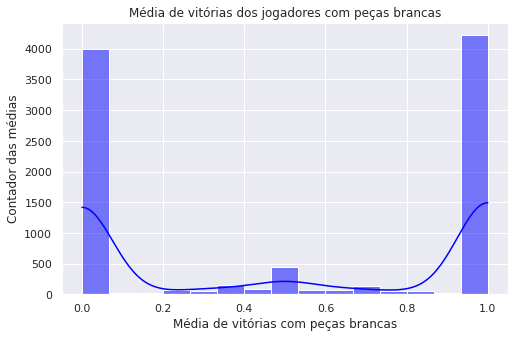

In [92]:
# Inicializando as variáveis
kde = True
color = 'blue'
text = 'Média de vitórias dos jogadores com peças brancas'
xlabel = 'Média de vitórias com peças brancas'
ylabel = 'Contador das médias'

CallHistplot(media_brancas, kde, color, text, xlabel, ylabel);

Retirando o valor de média sem vitória das peças brancas - 0

In [93]:
# Filtro para retirar o que não ganhou e o que obteve 100%
lst_vitorias_brancas = [media for media in media_brancas if media != 0]

kde = True
color = 'orange'
text = 'Média de vitórias dos jogadores com peças brancas'
xlabel = 'Média de vitórias com peças brancas'
ylabel = 'Contador das médias'

CallHistplot(lst_vitorias_brancas, kde, color, text, xlabel, ylabel);

Retirando os valores extremos peças brancas (0 e 1)

In [94]:
# Filtro para retirar o que não ganhou e o que obteve 100%
lst_vitorias_brancas = [media for media in media_brancas if media != 0 and media != 1]

kde = True
color = 'green'
text = 'Média de vitórias dos jogadores com peças brancas'
xlabel = 'Média de vitórias com peças brancas'
ylabel = 'Contador das médias'

CallHistplot(lst_vitorias_brancas, kde, color, text, xlabel, ylabel);

Histograma da média de peças pretas

In [95]:
# Inicializando as variáveis
kde = True
color = 'purple'
text = 'Média de vitórias dos jogadores com peças pretas'
xlabel = 'Média de vitórias com peças pretas'
ylabel = 'Contador das médias'

CallHistplot(media_pretas, kde, color, text, xlabel, ylabel);

Retirando o valor de média sem vitória das peças pretas - 0

In [96]:
# Filtro para retirar o que não ganhou e o que obteve 100%
lst_vitorias_pretas = [media for media in media_pretas if media != 0]

kde = True
color = 'black'
text = 'Média de vitórias dos jogadores com peças pretas'
xlabel = 'Média de vitórias com peças pretas'
ylabel = 'Contador das médias'

CallHistplot(lst_vitorias_pretas, kde, color, text, xlabel, ylabel);

Retirando os valores extremos peças pretas (0 e 1)

In [97]:
# Filtro para retirar o que não ganhou e o que obteve 100%
lst_vitorias_pretas = [media for media in media_pretas if media != 0 and media != 1]

kde = True
color = 'red'
text = 'Média de vitórias dos jogadores com peças pretas'
xlabel = 'Média de vitórias com peças pretas'
ylabel = 'Contador das médias'

CallHistplot(lst_vitorias_pretas, kde, color, text, xlabel, ylabel);

**Tratando o atributo moves**

Hoje o atributo moves reúne os movimentos do jogador em disputa. Tendo esse cenário, precisei separar a jogada e inserir mais dois novos atributos: movimento_brancas e movimentos_pretas para que consigamos trabalhar no objetivo de informar a cada jogada quem está mais próximo da vitória.

In [98]:
analise_movimentos = df_xadrez['moves'].values

print(f'Análise do vetor escolhido de movimentos: {analise_movimentos[0]}\n'
      f'Tamanho do vetor escolhido: {len(analise_movimentos[0])}')

Análise do vetor escolhido de movimentos: d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5 Bf4
Tamanho do vetor escolhido: 50


In [99]:
print(analise_movimentos)

['d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5 Bf4'
 'd4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6 Qe5+ Nxe5 c4 Bb4+'
 'e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc6 bxc6 Ra6 Nc4 a4 c3 a3 Nxa3 Rxa3 Rxa3 c4 dxc4 d5 cxd5 Qxd5 exd5 Be6 Ra8+ Ke7 Bc5+ Kf6 Bxf8 Kg6 Bxg7 Kxg7 dxe6 Kh6 exf7 Nf6 Rxh8 Nh5 Bxh5 Kg5 Rxh7 Kf5 Qf3+ Ke6 Bg4+ Kd6 Rh6+ Kc5 Qe3+ Kb5 c4+ Kb4 Qc3+ Ka4 Bd1#'
 ...
 'd4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd2 b6 Ne5 Nxe5 Bxe5 Nd7 Bxh7+ Kxh7 Qh5+ Kg8 Nf3 f6 Bf4 g5 Qg6+ Kh8 Nh4 Qe8 Qh6+ Kg8 Ng6 Kf7 Qh7#'
 'e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb6 c5 Nd5 Bc4 e6 Bxd5 exd5 Nc3 d4 Ne4 Bf5 f3 Nd7 b4 Nxe5 Bf4 f6 g4 Bxe4 fxe4 c6 Bxe5 fxe5 Nf3 Be7 Nxe5 Bf6 Nc4 O-O-O h4 h6 e5 b5 cxb6 Be7 bxa7 Kc7 a3 Rhf8 Kd2 Rf4 Rag1 d3 h5 Rf2+ Ke3 Re2+ Kf4 Rf8+ Kg3 Re3+ Nxe3 d2 Rd1 Bg5 Nf5 Kb7 Rhf1 Kxa7 Nd6 Rxf1 Rxf1 Kb6 e6 Kc7 Nf5 Kc8 e7 Kd7 a4 Bxe7 Nxe7 Kxe7 a5 Kd7 Rd1 Kc7 Rxd2 Kb7 Ra2 Ka6 Kf4 Kb5 a6 Kb6 a7 Kb5 a8=Q Kxb4 Qxc6 g5+ hxg6 Kb3 Rc2 Kb4 Qb7+ Ka3 Rc8'
 'd4 d5 Bf4 Na6 e3 e6

In [100]:
# Método que separá os movimentos realizados dos dois jogadores em uma partida
def CreatedNewColumnMoves(df):

  # Criando duas listas para os movimentos de peças brancas e pretas
  lst_mov_brancas = []
  lst_mov_pretas  = []

  # Tratando o atributo moves para transformar os movimentos em elementos de uma lista
  lst_movimentos = list(map(lambda x: x.split(), df))
  
  # Loop para percorrer a lista total de movimentos
  for movimentos in lst_movimentos:
    
    lst_mov_brancas.append(list(filter(lambda x: movimentos.index(x) % 2 == 0, movimentos)))
    lst_mov_pretas.append(list(filter(lambda x: movimentos.index(x) % 2 == 1, movimentos)))
  
  # Retornando os valores
  return lst_movimentos, lst_mov_brancas, lst_mov_pretas

In [101]:
lst_movimentos, lst_mv_br, lst_mv_pr = CreatedNewColumnMoves(analise_movimentos)

print(f'Tamanho das listas de movimentos:\n\tMovimentos = {len(lst_movimentos)}'
      f'\n\tPeças brancas = {len(lst_mv_br)}'
      f'\n\tPeças pretas = {len(lst_mv_pr)}')

Tamanho das listas de movimentos:
	Movimentos = 20058
	Peças brancas = 20058
	Peças pretas = 20058


In [102]:
print(f'Para o movimento de ambas, temos:\n\tTamanho:{len(lst_movimentos[6])}\n'
      f'\tE movimentos: {lst_movimentos[6]}\n\n'
      f'Para o movimento das brancas, temos:\n\tTamanho:{len(lst_mv_br[6])}\n'
      f'\tE movimentos: {lst_mv_br[6]}\n\nPara o movimento das pretas, temos:\n'
      f'\tTamanho:{len(lst_mv_pr[6])}\n\tE movimentos: {lst_mv_pr[6]}')

Para o movimento de ambas, temos:
	Tamanho:33
	E movimentos: ['d4', 'd5', 'e4', 'dxe4', 'Nc3', 'Nf6', 'f3', 'exf3', 'Nxf3', 'Nc6', 'Bb5', 'a6', 'Bd3', 'Bg4', 'O-O', 'Nxd4', 'Be2', 'Nxe2+', 'Qxe2', 'Bxf3', 'Qxf3', 'Qd4+', 'Be3', 'Qg4', 'Qxb7', 'Rd8', 'Qc6+', 'Nd7', 'Nd5', 'e6', 'Nxc7+', 'Ke7', 'Bd2']

Para o movimento das brancas, temos:
	Tamanho:17
	E movimentos: ['d4', 'e4', 'Nc3', 'f3', 'Nxf3', 'Bb5', 'Bd3', 'O-O', 'Be2', 'Qxe2', 'Qxf3', 'Be3', 'Qxb7', 'Qc6+', 'Nd5', 'Nxc7+', 'Bd2']

Para o movimento das pretas, temos:
	Tamanho:16
	E movimentos: ['d5', 'dxe4', 'Nf6', 'exf3', 'Nc6', 'a6', 'Bg4', 'Nxd4', 'Nxe2+', 'Bxf3', 'Qd4+', 'Qg4', 'Rd8', 'Nd7', 'e6', 'Ke7']


In [103]:
full_chess = df_xadrez.copy(deep=True)

full_chess['full_moves'] = lst_movimentos
full_chess['white_moves'] = lst_mv_br
full_chess['black_moves'] = lst_mv_pr

full_chess.head(1)

id  ...                    black_moves
0  TZJHLljE  ...  [d5, c6, e6, fxe6, Bb4+, Ba5]

[1 rows x 19 columns]

In [104]:
lst_attr = ['rated', 'turns', 'victory_status', 'winner', 'increment_code', 'white_id'
            ,'white_rating', 'black_id', 'black_rating', 'moves', 'full_moves', 'white_moves', 'black_moves'
            ,'opening_eco', 'opening_name', 'opening_ply']

full_chess = full_chess[lst_attr]

full_chess.head(3)

rated  turns  ...                            opening_name opening_ply
0  False     13  ...        Slav Defense: Exchange Variation           5
1   True     16  ...  Nimzowitsch Defense: Kennedy Variation           4
2   True     61  ...   King's Pawn Game: Leonardis Variation           3

[3 rows x 16 columns]

In [105]:
full_chess.describe()

turns  white_rating  black_rating   opening_ply
count  20058.000000  20058.000000  20058.000000  20058.000000
mean      60.465999   1596.631868   1588.831987      4.816981
std       33.570585    291.253376    291.036126      2.797152
min        1.000000    784.000000    789.000000      1.000000
25%       37.000000   1398.000000   1391.000000      3.000000
50%       55.000000   1567.000000   1562.000000      4.000000
75%       79.000000   1793.000000   1784.000000      6.000000
max      349.000000   2700.000000   2723.000000     28.000000

**Usando a série full_moves com dois targets: status_victory e winner**

In [106]:
attr = 'winner_le'

lst_le = lichess[attr].tolist()

full_chess[attr] = lst_le

In [107]:
# Inicialização do target
target = 'victory_status'

# Novo campo do target em numérico
target_new = 'victory_status_le'

full_chess[target_new] = le.fit_transform(df_xadrez[target])

In [108]:
attr_new = 'victory_status_oe'
attr     = 'victory_status'
lst_oe   = full_chess[attr].unique().tolist()

full_chess[attr_new] = ordinal_encoder(full_chess, lst_oe, attr, attr_new)

In [109]:
full_chess.head(10)

rated  turns victory_status  ... winner_le victory_status_le victory_status_oe
0  False     13      outoftime  ...         2                 2               0.0
1   True     16         resign  ...         0                 3               1.0
2   True     61           mate  ...         2                 1               2.0
3   True     61           mate  ...         2                 1               2.0
4   True     95           mate  ...         2                 1               2.0
5  False      5           draw  ...         1                 0               3.0
6   True     33         resign  ...         2                 3               1.0
7  False      9         resign  ...         0                 3               1.0
8   True     66         resign  ...         0                 3               1.0
9   True    119           mate  ...         2                 1               2.0

[10 rows x 19 columns]

Separando o conjunto em novo dataframe para os cenários de redes neurais

In [110]:
lst_target   = ['winner_le', 'victory_status_le']
lst_features = ['moves']

x_chess = full_chess[lst_features]
y_chess = full_chess[lst_target]

In [111]:
# Realizando HOLD OUT do conjunto x_chess e dividindo o conjunto de dados em 50%
size = 0.5

x_train_chess, x_test_chess, y_train_chess, y_test_chess = \
HoldOut(x_chess, y_chess, size)

--------------------------------
Conjunto de treino:
	Atributos = (10029, 1)
	Alvo      = (10029, 2)

Conjunto de Teste:
	Atributos = (10029, 1)
	Alvo      = (10029, 2)


**Análise do atributo turns**

Realizei essa análise, pois, a princípio o jogo de xadrez contabilizamos uma rodada com as ações dos dois jogadores. Mas neste conjunto, temos o número de jogadas e não a(s) rodada(s) de uma partida de xadrez.

In [112]:
kde = True
color = 'gray'
text = 'Distribuição dos valores de rodadas'
xlabel = 'Número de rodadas'
ylabel = 'Quantidade de vezes que ser repetiu'

CallHistplot(full_chess['turns'], kde, color, text, xlabel, ylabel);

**Usando a vetorização das strings para formar números**

In [113]:
# Inicializando as variáveis para a camada de vectorize
text_dataset = tf.data.Dataset.from_tensor_slices(x_train_chess['moves'].values)

max_features = 5000  # Máximo do tamanho do vocab.
max_len = 100 # Tamanho de acordo com a média de rodadas

# Criando a camada de vetorização
vectorize_layer = TextVectorization(
 max_tokens=max_features,
 output_mode='int',
 split='whitespace',
 output_sequence_length=max_len,
 name = 'Vectorize'
)

vectorize_layer.adapt(text_dataset)

In [114]:
print(len(vectorize_layer.get_vocabulary()))

2258


**Treinando as redes com a camada de embedding**

In [115]:
# Inicializando as variáveis
num_tokens = 5000
embedding_dim = 100

# Inicializando a camada do embedding
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer='uniform',
    trainable=True,
    name='Embedding'
)

**Redes Neurais** - Paradigma aprendizagem supervisionado

##### Será comum para todas as redes neurais

In [116]:
# Criando método que compila o modelo e o treina, gerando o seu histórico - para evitar código duplicado
def ModeloCompilaTreina(model, x, y, loss, batchSize, numberEpochs, callbk, opt, exe_metric, lst_metrics, exe_weight, dc_weight):
  # Inicializando as sementes para ter reproducibilidade
  seed(1)
  set_seed(2)

  # Compilando o modelo com ou sem métricas adicionais
  if (exe_metric):
    model.compile(loss=loss, optimizer=opt, metrics=lst_metrics)
  else:
    model.compile(loss=loss, optimizer=opt)

  # Treinando o modelo com ou sem peso
  if (exe_weight):
    hist_model = model.fit(x=x, y=y, batch_size=batchSize, epochs=numberEpochs, 
                           verbose=1, callbacks=[callbk], class_weight=dc_weight);
  else:
    hist_model = model.fit(x=x, y=y, batch_size=batchSize, epochs=numberEpochs, 
                           verbose=1, callbacks=[callbk]);

  # Retorna o histórico do treinamento em cada época
  return hist_model

In [117]:
# Taxa de aprendizado inicial de 0.001 e com decaimento em todas as épocas exponencial a -0.3
def scheduler(epochs, lr):
  if epochs < 10:
    return lr
  else:
    return np.clip(lr * tf.math.exp(-1e-2), 1e-5, 1e-3)

callbacklr = callbacks.LearningRateScheduler(scheduler)

In [118]:
# Método que plota os history dos modelos - evitar de duplicar código
def PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel):
  # Configurando o tamanho da figura
  plt.figure(figsize=(8,5))

  # Percorre a minha lista com o history de cada versão do modelo
  for p in lst_hist:
    plt.plot(p);

  plt.legend(legend, loc = location);
  plt.xlabel(xlabel);
  plt.ylabel(ylabel);
  plt.show();

**Convolucional**

In [119]:
def MyCNN(lst_neurons, filter, lst_activ, num_dropout):
  # Inicializando a entrada sem a definição de valores e passando string
  txt_sequences_input = Input(shape=(None,), dtype=tf.string, name='Entrada')

  # Camada de vetorização
  vect = vectorize_layer(txt_sequences_input)

  # Camada que gerará o embedding do jogo de Xadrez
  embedded_sequences = embedding_layer(vect)

  # Camada que olhará o vetor
  c1 = layers.Conv1D(lst_neurons[0], filter, activation=lst_activ[0], name='C1')(embedded_sequences)

  # Mais uma camada Conv1D
  c2 = layers.Conv1D(lst_neurons[0], filter, activation=lst_activ[0], name='C2')(c1)    

  # Possibilidade de gerar mais uma camada densa, antes da saída, seguida de dropout (primeiro sem)
  d1 = layers.Dense(lst_neurons[1], activation=lst_activ[0], name='D1')(c2)

  d2 = layers.Dropout(num_dropout)(d1)

  # Camada de Flatten para transformar o formato em 1
  fl = layers.Flatten()(d2)

  # Camada que gera a saída
  preds = layers.Dense(lst_neurons[2], activation=lst_activ[1], name='Camada_de_Saida')(fl)

  # Modelo sendo criado a partir da entrada com a saída feita
  modelConv = models.Model(txt_sequences_input, preds)

  # Resumo do modelo
  modelConv.summary()

  # Retornando o modelo
  return modelConv

In [120]:
# Realizando as inicializações das variáveis
n_class = len(y_train_chess['winner_le'].unique())
lst_neurons = [64, 32, n_class]
lst_activ   = ['relu', 'sigmoid']
filter = 3
num_dropout = 0

# Inicializando as sementes para ter reproducibilidade
seed(1)
set_seed(2)

# Chamando o método para geração da primeira CNN
modelConv_a = MyCNN(lst_neurons, filter, lst_activ, num_dropout)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Entrada (InputLayer)         [(None, None)]            0         
_________________________________________________________________
Vectorize (TextVectorization (None, 100)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 100, 100)          500000    
_________________________________________________________________
C1 (Conv1D)                  (None, 98, 64)            19264     
_________________________________________________________________
C2 (Conv1D)                  (None, 96, 64)            12352     
_________________________________________________________________
D1 (Dense)                   (None, 96, 32)            2080      
_________________________________________________________________
dropout (Dropout)            (None, 96, 32)            0     

In [121]:
# Inicializando a taxa de aprendizado, a loss, o batch_size, o número de épocas...
# O intuito é parametrizar o método para compilar
lr = 1e-3
loss = 'sparse_categorical_crossentropy'
batchSize = 16
numberEpochs = 100
opt = optimizers.Adam(lr)
exe_metric = True
exe_weight = False
metrics = keras.metrics.sparse_categorical_accuracy
dc_weight = {0:1e-1, 1:9e-1}

# Chamando o método ModeloCompilaTreina para recuperar o histórico do treinamento
cnn_hist = ModeloCompilaTreina(modelConv_a, x_train_chess['moves'], y_train_chess['winner_le'], loss, batchSize, numberEpochs, 
                                 callbacklr, opt, exe_metric, metrics, exe_weight, dc_weight)

Epoch 1/100
627/627 [==============================] - 13s 9ms/step - loss: 0.8081 - sparse_categorical_accuracy: 0.5459
Epoch 2/100
627/627 [==============================] - 5s 9ms/step - loss: 0.4251 - sparse_categorical_accuracy: 0.8491
Epoch 3/100
627/627 [==============================] - 5s 9ms/step - loss: 0.3300 - sparse_categorical_accuracy: 0.8823
Epoch 4/100
627/627 [==============================] - 5s 8ms/step - loss: 0.2400 - sparse_categorical_accuracy: 0.9138
Epoch 5/100
627/627 [==============================] - 5s 8ms/step - loss: 0.1734 - sparse_categorical_accuracy: 0.9396
Epoch 6/100
627/627 [==============================] - 5s 8ms/step - loss: 0.1182 - sparse_categorical_accuracy: 0.9590
Epoch 7/100
627/627 [==============================] - 5s 8ms/step - loss: 0.0807 - sparse_categorical_accuracy: 0.9691
Epoch 8/100
627/627 [==============================] - 5s 8ms/step - loss: 0.0590 - sparse_categorical_accuracy: 0.9790
Epoch 9/100
627/627 [==================

In [122]:
# Inicializando as variáveis
map_metric = ['loss']
lst_hist = [cnn_hist.history[map_metric[0]]]
legend = ["Entropia Cruzada"]
location = "upper right"
xlabel = 'Número de Épocas'
ylabel = 'Valores da Perda'

# Chamando o método para exibir graficamente o resultado
PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel)

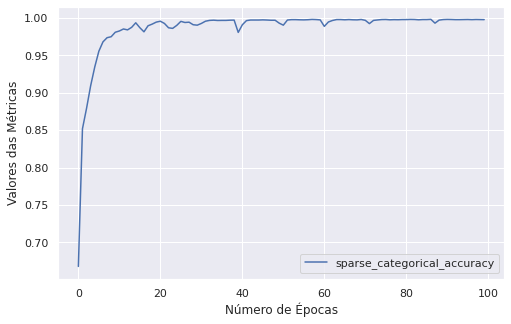

In [123]:
# Inicializando as variáveis
map_metric = 'sparse_categorical_accuracy'
lst_hist = [cnn_hist.history[map_metric]]
legend = [map_metric]
location = "lower right"
xlabel = 'Número de Épocas'
ylabel = 'Valores das Métricas'

# Chamando o método para exibir graficamente o resultado
PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel)

In [124]:
# Inicializando as variáveis
map_metric = 'lr'
lst_hist = [cnn_hist.history[map_metric]]
legend = ["Taxa de Aprendizado"]
location = "upper right"
xlabel = 'Número de Épocas'
ylabel = 'Valores para a taxa de aprendizado'

# Chamando o método para exibir graficamente o resultado
PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel)

In [125]:
# Realizando o teste
score_cnn_a = modelConv_a.evaluate(x_test_chess, y_test_chess['winner_le'], verbose=0);

print(f'Cenário do Teste - Conjunto de Teste:\n\tAcurácia = '
      f'{score_cnn_a[1]:.4f}')

Cenário do Teste - Conjunto de Teste:
	Acurácia = 0.8062


In [126]:
# Gera uma lista de arrays, dentro de cada array tem o melhor resultado para cada uma das classes
y_pred_cnn = modelConv_a.predict(x_test_chess)

# List comprehensions para obter os índices com os melhores valores
y_pred_cnn_a = [np.argmax(i) for i in y_pred_cnn]

score_cnn_f1 = f1_score(y_test_chess['winner_le'], y_pred_cnn_a, average = 'weighted')

print(f'Cenário do Teste - Conjunto de Teste:\n\tF1_Score = '
      f'{score_cnn_f1:.4f}')

Cenário do Teste - Conjunto de Teste:
	F1_Score = 0.8000


In [127]:
# Criarei um dicionário para sparse_categorical_accuracy para as redes neurais
scores_nn_sca = {}

# Criarei um dicionário para f1_score para as redes neurais
scores_nn_f1s = {}

In [128]:
name = 'CNN - Sparse_Categorical_Accuracy'

scores_nn_sca[name] = round(score_cnn_a[1], 4)

In [129]:
name = 'CNN - F1_Score'

scores_nn_f1s[name] = round(score_cnn_f1, 4)

**Redes Neurais Recorrentes**

In [130]:
# Criar o modelo de rede neural recorrente, usando LSTM ou GRU
def GenerateModelRNN(obj, lst_neurons, lst_activ, num_dropout):
  # Entrada variável
  input = layers.Input(shape=(None,), dtype=tf.string, name='Entrada')

  # Camada de vetorização
  vect = vectorize_layer(input)

  # Camada que gerará o embedding do jogo de Xadrez
  embedded_sequences = embedding_layer(vect)

  # Primeira camada do modelo de rede recorrente
  rnn1 = obj(lst_neurons[0], activation=lst_activ[0], name='rnn1')\
  (embedded_sequences)

  # Camada de Flatten para transformar o formato em 1
  fl = layers.Flatten()(rnn1)
  
  # Criando uma nova camada de saída que recebe como entrada a anterior
  rnn_out = layers.Dense(lst_neurons[2], activation=lst_activ[1], name='Dense_Out_RNN')(fl)

  # Criando um novo modelo tendo essa nova camada como saída
  model = models.Model(input, rnn_out)

  # Gera o resumo do modelo
  model.summary()

  # Retornará o modelo
  return model

In [131]:
# formato deve ser [samples, time steps, 1 features]
rnn_train = np.reshape(np.array(x_train_chess), (x_train_chess.shape[0], 1, 1))
rnn_test = np.reshape(np.array(x_test_chess), (x_test_chess.shape[0], 1, 1))

print(f'Cenário de treino = {rnn_train.shape}\nCenário '
      f'de teste  = {rnn_test.shape}')

Cenário de treino = (10029, 1, 1)
Cenário de teste  = (10029, 1, 1)


**LSTM**

In [132]:
# Inicializando as variáveis
neurons = [32, 16, n_class]
activ   = ['relu', 'sigmoid']
num_dropout = 2e-1
obj = layers.LSTM

# Sementes para manter reproducibilidade dos testes
seed(1)
set_seed(2)

# Chamando o método que gerará o modelo LSTM
lstm_model_a = GenerateModelRNN(obj, neurons, activ, num_dropout)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Entrada (InputLayer)         [(None, None)]            0         
_________________________________________________________________
Vectorize (TextVectorization (None, 100)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 100, 100)          500000    
_________________________________________________________________
rnn1 (LSTM)                  (None, 32)                17024     
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
Dense_Out_RNN (Dense)        (None, 3)                 99        
Total params: 517,123
Trainable params: 517,123
Non-trainable params: 0
_____________________________________________________

In [133]:
# Inicializando a taxa de aprendizado, a loss, o batch_size, o número de épocas...
# O intuito é parametrizar o método para compilar
lr = 1e-3
loss = 'sparse_categorical_crossentropy'
batchSize = 16
numberEpochs = 30
opt = optimizers.Adam(lr)
exe_metric = True
exe_weight = False
metrics = keras.metrics.sparse_categorical_accuracy
dc_weight = {0:1e-1, 1:9e-1}

y_train_cs = np.array(y_train_chess['winner_le'])

# Chamando o método ModeloCompilaTreina para recuperar o histórico do treinamento
lstm_hist = ModeloCompilaTreina(lstm_model_a, rnn_train, y_train_cs, loss, batchSize, numberEpochs, 
                                 callbacklr, opt, exe_metric, metrics, exe_weight, dc_weight)

Epoch 1/30
627/627 [==============================] - 99s 157ms/step - loss: 3.2159 - sparse_categorical_accuracy: 0.4803
Epoch 2/30
627/627 [==============================] - 102s 163ms/step - loss: 0.8443 - sparse_categorical_accuracy: 0.5038
Epoch 3/30
627/627 [==============================] - 98s 156ms/step - loss: 1.0139 - sparse_categorical_accuracy: 0.5301
Epoch 4/30
627/627 [==============================] - 98s 156ms/step - loss: 0.8241 - sparse_categorical_accuracy: 0.5328
Epoch 5/30
627/627 [==============================] - 97s 155ms/step - loss: 0.8196 - sparse_categorical_accuracy: 0.5244
Epoch 6/30
627/627 [==============================] - 98s 157ms/step - loss: 0.8100 - sparse_categorical_accuracy: 0.5299
Epoch 7/30
627/627 [==============================] - 97s 155ms/step - loss: 0.8028 - sparse_categorical_accuracy: 0.5359
Epoch 8/30
627/627 [==============================] - 100s 159ms/step - loss: 0.7916 - sparse_categorical_accuracy: 0.5466
Epoch 9/30
627/627 [==

In [134]:
# Inicializando as variáveis
map_metric = ['loss']
lst_hist = [lstm_hist.history[map_metric[0]]]
legend = ["Entropia Cruzada"]
location = "upper right"
xlabel = 'Número de Épocas'
ylabel = 'Valores da Perda'

# Chamando o método para exibir graficamente o resultado
PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel)

In [135]:
# Inicializando as variáveis
map_metric = 'sparse_categorical_accuracy'
lst_hist = [lstm_hist.history[map_metric]]
legend = [map_metric]
location = "lower right"
xlabel = 'Número de Épocas'
ylabel = 'Valores das Métricas'

# Chamando o método para exibir graficamente o resultado
PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel)

In [136]:
# Inicializando as variáveis
map_metric = 'lr'
lst_hist = [lstm_hist.history[map_metric]]
legend = ["Taxa de Aprendizado"]
location = "upper right"
xlabel = 'Número de Épocas'
ylabel = 'Valores para a taxa de aprendizado'

# Chamando o método para exibir graficamente o resultado
PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel)

In [137]:
# Tranformando a variável em numpy
y_test_cs = np.array(y_test_chess['winner_le']) 

# Realizando o teste
score_rnn_lstm_a = lstm_model_a.evaluate(rnn_test, y_test_cs, verbose=0);

print(f'Cenário do Teste - Conjunto de Teste:\n\tAcurácia = '
      f'{score_rnn_lstm_a[1]:.4f}')

Cenário do Teste - Conjunto de Teste:
	Acurácia = 0.6384


In [138]:
# Gera uma lista de arrays, dentro de cada array tem o melhor resultado para cada uma das classes
y_pred_lstm = lstm_model_a.predict(rnn_test)

# List comprehensions para obter os índices com os melhores valores
y_pred_lstm_a = [np.argmax(i) for i in y_pred_lstm]

score_lstm_f1 = f1_score(y_test_chess['winner_le'], y_pred_lstm_a, average = 'weighted')

print(f'Cenário do Teste - Conjunto de Teste:\n\tF1_Score = '
      f'{score_lstm_f1:.4f}')

Cenário do Teste - Conjunto de Teste:
	F1_Score = 0.6212


In [139]:
name = 'LSTM - Sparse_Categorical_Accuracy'

scores_nn_sca[name] = round(score_rnn_lstm_a[1], 4)

In [140]:
name = 'LSTM - F1_Score'

scores_nn_f1s[name] = round(score_lstm_f1, 4)

**GRU**

In [141]:
# Inicializando as variáveis
neurons = [32, 16, n_class]
activs = ['relu', 'sigmoid']
num_dropout = 2e-1
obj = layers.GRU

# Sementes para manter reproducibilidade dos testes
seed(1)
set_seed(2)

# Chamando o método que gerará o modelo GRU
gru_model_a = GenerateModelRNN(obj, neurons, activs, num_dropout)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Entrada (InputLayer)         [(None, None)]            0         
_________________________________________________________________
Vectorize (TextVectorization (None, 100)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 100, 100)          500000    
_________________________________________________________________
rnn1 (GRU)                   (None, 32)                12864     
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)                0         
_________________________________________________________________
Dense_Out_RNN (Dense)        (None, 3)                 99        
Total params: 512,963
Trainable params: 512,963
Non-trainable params: 0
_____________________________________________________

In [142]:
# Inicializando a taxa de aprendizado, a loss, o batch_size, o número de épocas...
# O intuito é parametrizar o método para compilar
lr = 1e-3
loss = 'sparse_categorical_crossentropy'
batchSize = 16
numberEpochs = 30
opt = optimizers.Adam(lr)
exe_metric = True
exe_weight = False
metrics = keras.metrics.sparse_categorical_accuracy
dc_weight = {0:1e-1, 1:9e-1}

y_train_cs = np.array(y_train_chess['winner_le'])

# Chamando o método ModeloCompilaTreina para recuperar o histórico do treinamento
gru_hist = ModeloCompilaTreina(gru_model_a, rnn_train, y_train_cs, loss, batchSize, numberEpochs, 
                                 callbacklr, opt, exe_metric, metrics, exe_weight, dc_weight)

Epoch 1/30
627/627 [==============================] - 124s 196ms/step - loss: 0.8167 - sparse_categorical_accuracy: 0.5370
Epoch 2/30
627/627 [==============================] - 124s 198ms/step - loss: 0.5805 - sparse_categorical_accuracy: 0.7625
Epoch 3/30
627/627 [==============================] - 127s 203ms/step - loss: 0.4937 - sparse_categorical_accuracy: 0.8075
Epoch 4/30
627/627 [==============================] - 124s 198ms/step - loss: 0.4517 - sparse_categorical_accuracy: 0.8332
Epoch 5/30
627/627 [==============================] - 123s 196ms/step - loss: 0.4130 - sparse_categorical_accuracy: 0.8453
Epoch 6/30
627/627 [==============================] - 122s 195ms/step - loss: 0.3655 - sparse_categorical_accuracy: 0.8717
Epoch 7/30
627/627 [==============================] - 121s 193ms/step - loss: 0.3208 - sparse_categorical_accuracy: 0.8854
Epoch 8/30
627/627 [==============================] - 124s 198ms/step - loss: 0.2797 - sparse_categorical_accuracy: 0.9038
Epoch 9/30
627/6

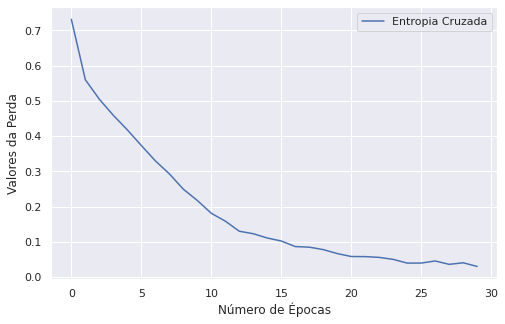

In [143]:
# Inicializando as variáveis
map_metric = ['loss']
lst_hist = [gru_hist.history[map_metric[0]]]
legend = ["Entropia Cruzada"]
location = "upper right"
xlabel = 'Número de Épocas'
ylabel = 'Valores da Perda'

# Chamando o método para exibir graficamente o resultado
PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel)

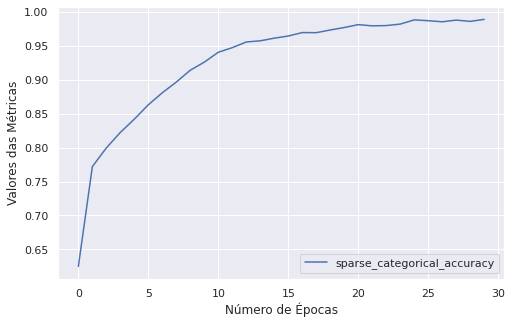

In [144]:
# Inicializando as variáveis
map_metric = 'sparse_categorical_accuracy'
lst_hist = [gru_hist.history[map_metric]]
legend = [map_metric]
location = "lower right"
xlabel = 'Número de Épocas'
ylabel = 'Valores das Métricas'

# Chamando o método para exibir graficamente o resultado
PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel)

In [145]:
# Inicializando as variáveis
map_metric = 'lr'
lst_hist = [gru_hist.history[map_metric]]
legend = ["Taxa de Aprendizado"]
location = "upper right"
xlabel = 'Número de Épocas'
ylabel = 'Valores para a taxa de aprendizado'

# Chamando o método para exibir graficamente o resultado
PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel)

In [146]:
# Tranformando a variável em numpy
y_test_cs = np.array(y_test_chess['winner_le']) 

# Realizando o teste
score_rnn_gru_a = gru_model_a.evaluate(rnn_test, y_test_cs, verbose=0);

print(f'Cenário do Teste - Conjunto T:\n\tAcurácia = '
      f'{score_rnn_gru_a[1]:.4f}')

Cenário do Teste - Conjunto T:
	Acurácia = 0.6852


In [147]:
# Gera uma lista de arrays, dentro de cada array tem o melhor resultado para cada uma das classes
y_pred_gru = gru_model_a.predict(rnn_test)

# List comprehensions para obter os índices com os melhores valores
y_pred_gru_a = [np.argmax(i) for i in y_pred_gru]

score_gru_f1 = f1_score(y_test_chess['winner_le'], y_pred_gru_a, average = 'weighted')

print(f'Cenário do Teste - Conjunto de Teste:\n\tF1_Score = '
      f'{score_gru_f1:.4f}')

Cenário do Teste - Conjunto de Teste:
	F1_Score = 0.6853


In [148]:
name = 'GRU - Sparse_Categorical_Accuracy'

scores_nn_sca[name] = round(score_rnn_gru_a[1], 4)

In [149]:
name = 'GRU - F1_Score'

scores_nn_f1s[name] = round(score_gru_f1, 4)

**Rede Neural Convolucional + Recorrente**

#### LSTM

In [150]:
# Construir o modelo CNN + Recorrente - gerando um método para evitar duplicação de código
def RedeNeuralDensa(model, camada, lst_neurons, lst_activ):

  # Obtendo a saída da camada de código do modelo convolucional (camada de saída)
  base_cnn = model.get_layer(camada).output

  # Primeira camada do modelo de rede recorrente
  rnn1 = obj(lst_neurons[0], activation=lst_activ[0], name='rnn1')\
  (base_cnn)

  # Camada de Flatten para transformar o formato em 1
  fl = layers.Flatten()(rnn1)

  # Criando uma nova camada de saída que recebe como entrada a anterior
  saida_nova = layers.Dense(lst_neurons[2], activation=lst_activ[1], name='Dense_out_cnn_rnn')(rnn1)

  # Criando um novo modelo tendo essa nova camada como saída
  model = models.Model(model.inputs, saida_nova)

  # Modelo final
  model.summary()

  return model

In [151]:
# Inicializando as variáveis
neurons = [32, 16, n_class]
activ   = ['relu', 'sigmoid']
num_dropout = 2e-1
obj = layers.LSTM

# Sementes para manter reproducibilidade dos testes
seed(1)
set_seed(2)

# Chamando o método que gerará o modelo LSTM
lstm_model_b = GenerateModelRNN(obj, neurons, activ, num_dropout)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Entrada (InputLayer)         [(None, None)]            0         
_________________________________________________________________
Vectorize (TextVectorization (None, 100)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 100, 100)          500000    
_________________________________________________________________
rnn1 (LSTM)                  (None, 32)                17024     
_________________________________________________________________
flatten_3 (Flatten)          (None, 32)                0         
_________________________________________________________________
Dense_Out_RNN (Dense)        (None, 3)                 99        
Total params: 517,123
Trainable params: 517,123
Non-trainable params: 0
_____________________________________________________

In [152]:
# Inicializando a taxa de aprendizado, a loss, o batch_size, o número de épocas...
# O intuito é parametrizar o método para compilar
lr = 1e-3
loss = 'sparse_categorical_crossentropy'
batchSize = 16
numberEpochs = 30
opt = optimizers.Adam(lr)
exe_metric = True
exe_weight = False
metrics = keras.metrics.sparse_categorical_accuracy
dc_weight = {0:1e-1, 1:9e-1}

y_train_cs = np.array(y_train_chess['winner_le'])

# Chamando o método ModeloCompilaTreina para recuperar o histórico do treinamento
lstm_hist_b = ModeloCompilaTreina(lstm_model_b, rnn_train, y_train_cs, loss, batchSize, numberEpochs, 
                                 callbacklr, opt, exe_metric, metrics, exe_weight, dc_weight)

Epoch 1/30
627/627 [==============================] - 101s 159ms/step - loss: 0.8369 - sparse_categorical_accuracy: 0.5369
Epoch 2/30
627/627 [==============================] - 99s 158ms/step - loss: 1.0424 - sparse_categorical_accuracy: 0.7637
Epoch 3/30
627/627 [==============================] - 101s 162ms/step - loss: 0.8216 - sparse_categorical_accuracy: 0.6178
Epoch 4/30
627/627 [==============================] - 99s 158ms/step - loss: 0.6653 - sparse_categorical_accuracy: 0.7232
Epoch 5/30
627/627 [==============================] - 99s 158ms/step - loss: 0.6217 - sparse_categorical_accuracy: 0.7504
Epoch 6/30
627/627 [==============================] - 99s 158ms/step - loss: 0.5883 - sparse_categorical_accuracy: 0.7694
Epoch 7/30
627/627 [==============================] - 98s 157ms/step - loss: 0.5653 - sparse_categorical_accuracy: 0.7728
Epoch 8/30
627/627 [==============================] - 99s 158ms/step - loss: 0.5390 - sparse_categorical_accuracy: 0.7866
Epoch 9/30
627/627 [==

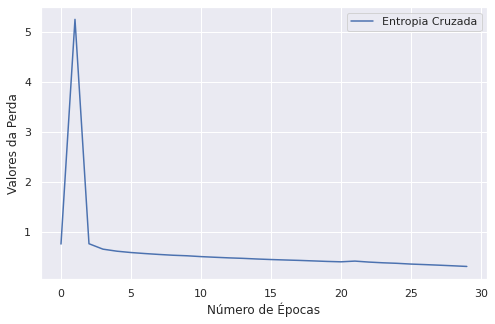

In [153]:
# Inicializando as variáveis
map_metric = ['loss']
lst_hist = [lstm_hist_b.history[map_metric[0]]]
legend = ["Entropia Cruzada"]
location = "upper right"
xlabel = 'Número de Épocas'
ylabel = 'Valores da Perda'

# Chamando o método para exibir graficamente o resultado
PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel)

In [154]:
# Inicializando as variáveis
map_metric = 'sparse_categorical_accuracy'
lst_hist = [lstm_hist_b.history[map_metric]]
legend = [map_metric]
location = "lower right"
xlabel = 'Número de Épocas'
ylabel = 'Valores das Métricas'

# Chamando o método para exibir graficamente o resultado
PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel)

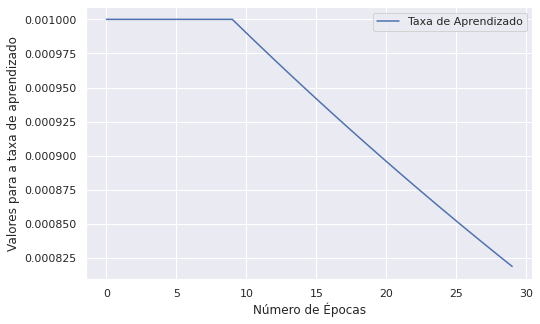

In [155]:
# Inicializando as variáveis
map_metric = 'lr'
lst_hist = [lstm_hist_b.history[map_metric]]
legend = ["Taxa de Aprendizado"]
location = "upper right"
xlabel = 'Número de Épocas'
ylabel = 'Valores para a taxa de aprendizado'

# Chamando o método para exibir graficamente o resultado
PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel)

In [156]:
# Tranformando a variável em numpy
y_test_cs = np.array(y_test_chess['winner_le']) 

# Realizando o teste
score_rnn_lstm_b = lstm_model_b.evaluate(rnn_test, y_test_cs, verbose=0);

print(f'Cenário do Teste - Conjunto T:\n\tAcurácia = '
      f'{score_rnn_lstm_b[1]:.4f}')

Cenário do Teste - Conjunto T:
	Acurácia = 0.6812


In [157]:
# Gera uma lista de arrays, dentro de cada array tem o melhor resultado para cada uma das classes
y_pred_lstm_b = lstm_model_b.predict(rnn_test)

# List comprehensions para obter os índices com os melhores valores
y_pred_lstm_b2 = [np.argmax(i) for i in y_pred_lstm_b]

score_lstm_f1_b = f1_score(y_test_chess['winner_le'], y_pred_lstm_b2, average = 'weighted')

print(f'Cenário do Teste - Conjunto de Teste:\n\tF1_Score = '
      f'{score_lstm_f1_b:.4f}')

Cenário do Teste - Conjunto de Teste:
	F1_Score = 0.6703


In [158]:
name = 'CNN + LSTM - Sparse_Categorical_Accuracy'

scores_nn_sca[name] = round(score_rnn_lstm_b[1], 4)

In [159]:
name = 'CNN + LSTM - F1_Score'

scores_nn_f1s[name] = round(score_lstm_f1_b, 4)

#### GRU

In [160]:
# Inicializando as variáveis
neurons = [32, 16, n_class]
activs = ['relu', 'sigmoid']
num_dropout = 2e-1
obj = layers.GRU

# Sementes para manter reproducibilidade dos testes
seed(1)
set_seed(2)

# Chamando o método que gerará o modelo GRU
gru_model_b = GenerateModelRNN(obj, neurons, activs, num_dropout)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Entrada (InputLayer)         [(None, None)]            0         
_________________________________________________________________
Vectorize (TextVectorization (None, 100)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 100, 100)          500000    
_________________________________________________________________
rnn1 (GRU)                   (None, 32)                12864     
_________________________________________________________________
flatten_4 (Flatten)          (None, 32)                0         
_________________________________________________________________
Dense_Out_RNN (Dense)        (None, 3)                 99        
Total params: 512,963
Trainable params: 512,963
Non-trainable params: 0
_____________________________________________________

In [161]:
# Inicializando a taxa de aprendizado, a loss, o batch_size, o número de épocas...
# O intuito é parametrizar o método para compilar
lr = 1e-3
loss = 'sparse_categorical_crossentropy'
batchSize = 16
numberEpochs = 30
opt = optimizers.Adam(lr)
exe_metric = True
exe_weight = False
metrics = keras.metrics.sparse_categorical_accuracy
dc_weight = {0:1e-1, 1:9e-1}

y_train_cs = np.array(y_train_chess['winner_le'])

# Chamando o método ModeloCompilaTreina para recuperar o histórico do treinamento
gru_hist_b = ModeloCompilaTreina(gru_model_b, rnn_train, y_train_cs, loss, batchSize, numberEpochs, 
                                 callbacklr, opt, exe_metric, metrics, exe_weight, dc_weight)

Epoch 1/30
627/627 [==============================] - 125s 198ms/step - loss: 0.7440 - sparse_categorical_accuracy: 0.6025
Epoch 2/30
627/627 [==============================] - 126s 200ms/step - loss: 0.4012 - sparse_categorical_accuracy: 0.8521
Epoch 3/30
627/627 [==============================] - 125s 199ms/step - loss: 0.2896 - sparse_categorical_accuracy: 0.8964
Epoch 4/30
627/627 [==============================] - 125s 200ms/step - loss: 0.2257 - sparse_categorical_accuracy: 0.9239
Epoch 5/30
627/627 [==============================] - 125s 199ms/step - loss: 0.1777 - sparse_categorical_accuracy: 0.9392
Epoch 6/30
627/627 [==============================] - 124s 198ms/step - loss: 0.1335 - sparse_categorical_accuracy: 0.9575
Epoch 7/30
627/627 [==============================] - 124s 198ms/step - loss: 0.1086 - sparse_categorical_accuracy: 0.9611
Epoch 8/30
627/627 [==============================] - 125s 199ms/step - loss: 0.0855 - sparse_categorical_accuracy: 0.9712
Epoch 9/30
627/6

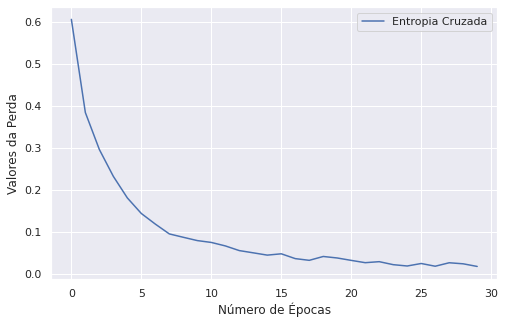

In [162]:
# Inicializando as variáveis
map_metric = ['loss']
lst_hist = [gru_hist_b.history[map_metric[0]]]
legend = ["Entropia Cruzada"]
location = "upper right"
xlabel = 'Número de Épocas'
ylabel = 'Valores da Perda'

# Chamando o método para exibir graficamente o resultado
PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel)

In [163]:
# Inicializando as variáveis
map_metric = 'sparse_categorical_accuracy'
lst_hist = [gru_hist_b.history[map_metric]]
legend = [map_metric]
location = "lower right"
xlabel = 'Número de Épocas'
ylabel = 'Valores das Métricas'

# Chamando o método para exibir graficamente o resultado
PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel)

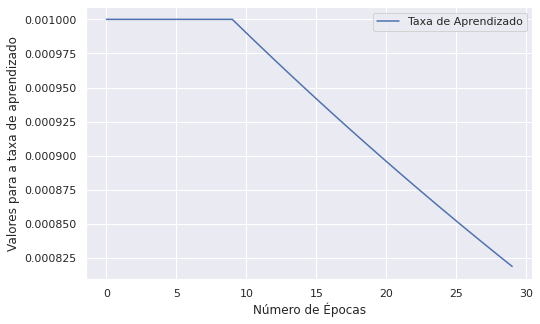

In [164]:
# Inicializando as variáveis
map_metric = 'lr'
lst_hist = [gru_hist_b.history[map_metric]]
legend = ["Taxa de Aprendizado"]
location = "upper right"
xlabel = 'Número de Épocas'
ylabel = 'Valores para a taxa de aprendizado'

# Chamando o método para exibir graficamente o resultado
PlotHistoryModels(lst_hist, legend, location, xlabel, ylabel)

In [165]:
# Tranformando a variável em numpy
y_test_cs = np.array(y_test_chess['winner_le']) 

# Realizando o teste
score_rnn_gru_b = gru_model_b.evaluate(rnn_test, y_test_cs, verbose=0);

print(f'Cenário do Teste - Conjunto T:\n\tAcurácia = '
      f'{score_rnn_gru_b[1]:.4f}')

Cenário do Teste - Conjunto T:
	Acurácia = 0.6953


In [166]:
# Gera uma lista de arrays, dentro de cada array tem o melhor resultado para cada uma das classes
y_pred_gru_b = gru_model_b.predict(rnn_test)

# List comprehensions para obter os índices com os melhores valores
y_pred_gru_b2 = [np.argmax(i) for i in y_pred_gru_b]

score_gru_f1_b = f1_score(y_test_chess['winner_le'], y_pred_gru_b2, average = 'weighted')

print(f'Cenário do Teste - Conjunto de Teste:\n\tF1_Score = '
      f'{score_gru_f1_b:.4f}')

Cenário do Teste - Conjunto de Teste:
	F1_Score = 0.6932


In [167]:
name = 'CNN + GRU - Sparse_Categorical_Accuracy'

scores_nn_sca[name] = round(score_rnn_gru_b[1], 4)

In [168]:
name = 'CNN + GRU - F1_Score'

scores_nn_f1s[name] = round(score_gru_f1_b, 4)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


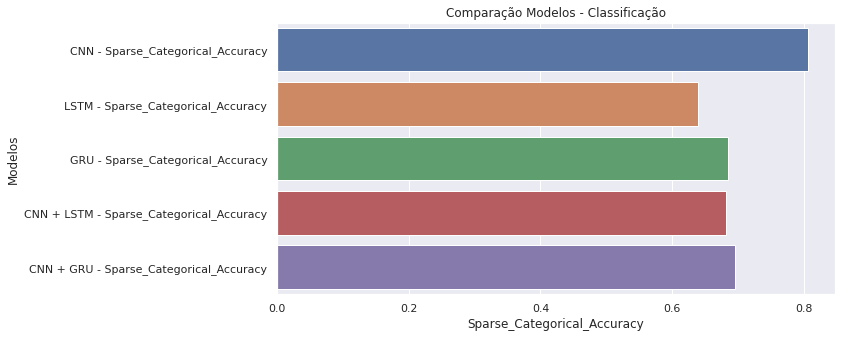

In [169]:
# Gráfico da métrica da acurácia categórica esparsa - NNs
plt.figure(figsize=(10, 5))

sns.barplot(list(scores_nn_sca.values()), list(scores_nn_sca.keys()))
plt.xticks(np.arange(0, 0.9, 0.2));
plt.xlabel('Sparse_Categorical_Accuracy');
plt.ylabel('Modelos');
plt.title('Comparação Modelos - Classificação');

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


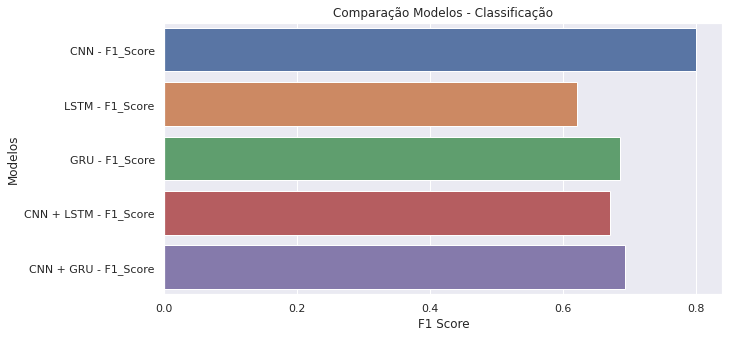

In [170]:
# Gráfico da métrica do f1_score - NNs
plt.figure(figsize=(10, 5))

sns.barplot(list(scores_nn_f1s.values()), list(scores_nn_f1s.keys()))
plt.xticks(np.arange(0, 0.9, 0.2));
plt.xlabel('F1 Score');
plt.ylabel('Modelos');
plt.title('Comparação Modelos - Classificação');